In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics
import sklearn.discriminant_analysis as DA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import shapiro
from scipy.stats import uniform
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization, UtilityFunction
import time
from hyperopt import hp, fmin, tpe
import random, timeit, copy
import matplotlib.pyplot as plt  
import time, sys
from IPython.display import clear_output
import pywt
import pickle
import os


# Helper functions
def remove_outliers(df,columns,n_std):
    """
    This function removes outliers found at +/- n_std's away from the mean. 
    """
    for col in columns:
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] >= mean-(n_std*sd))&(df[col] <= mean+(n_std*sd))]
        
    return df

def latex_tabulate(temp_dFrame):
    for i in range(temp_dFrame.shape[0]):
        temp_mod = temp_dFrame.iloc[i]['Model']
        temp_test_acc = temp_dFrame.iloc[i]['Testing Accuracy']
        temp_test_std = temp_dFrame.iloc[i]['Std. Testing Accuracy']
        temp_train_acc = temp_dFrame.iloc[i]['Training Accuracy']
        temp_train_std = temp_dFrame.iloc[i]['Std. Training Accuracy']
        temp_num_pred = temp_dFrame.iloc[i]['# Predictors Used in Training']
        print(f'{temp_dFrame.index[i]} & {temp_mod} & {temp_test_acc:.3} ({temp_test_std:.3}) & {temp_train_acc:.3} ({temp_train_std:.3}) & {temp_num_pred} '+r'\\', sep='')
        print('\hline')
    return

def round_dFrame(dFrame,cols,rounds):
    temp_dFrame = dFrame.copy() # Copy frame
    for col, rounder in zip(cols, rounds):
        temp_dFrame[col] = temp_dFrame[col].astype(float).round(rounder)
        
    return temp_dFrame

def update_progress(progress,frac):
    """
    Helper function to display the progress of the tests.
    Source: https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
    """
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = str(frac)+" Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

    
# load MIRS.csv dataset and MIRS_features dataset
features = pd.read_csv('MIRS_Data/MIRS_features.csv')
X = dataset = pd.read_csv('Wavelet_Features.csv', header= None)
X.columns = ['slope', 'Spectral Mode', 'LS', 'RS', 'LT', 'RT', 'B', 'pt L', 'pt R', 'max curv', 'k', 'k_central']
dataset.columns = ['slope', 'Spectral Mode', 'LS', 'RS', 'LT', 'RT', 'B', 'pt L', 'pt R', 'max curv', 'k', 'k_central']
MIRS = pd.read_csv("MIRS_Data/MIRS_cleaned.csv")

# Define the Stratified CV split that will be used in grid searches
cv_split = StratifiedKFold(n_splits = 10)
if not os.path.exists("PythonResults"):
    os.mkdir("PythonResults")
    
if not os.path.exists("KDE_Plots"):
    os.mkdir("KDE_Plots")
    
if not os.path.exists("Training_Testing_Accuracy_Plots"):
    os.mkdir("Training_Testing_Accuracy_Plots")
sns.set()

milk_traits_rename = {"RCT": "RCT", "k20": "k20", "a30": "a30", "a60":"a30", "Casein_micelle_size": "CMS",
                     "Native_pH": "pH", "Heat_stability": "HS","Urea_Content": "TUC", "Fat_content": "TFC",
                     "Lactose_content": "TLC","Protein_content": "TPC","alpha_s1_casein": "alpha_S1-CN",
                     "alpha_s2_casein":"alpha_S2-CN","beta_casein":"beta-CN", "kappa_casein":"kappa-CN",
                     "alpha_lactalbumin": "alpha-L","beta_lactoglobulin_a":"beta-LGA","beta_lactoglobulin_b": "beta-LGB" }

wavelet_features_rename = {'slope': 'S', 'Spectral Mode':'SM', 'LS': 'LS', 'RS':'RS', 'LT': 'LT',
                           'RT':'RT', 'B':'B', 'pt L':'LTP', 'pt R':'RTP', 'max curv':'MC','k':'K', 'k_central':'KC'}

## Categorize and Explore Data

In [2]:
protein = features.loc[:,'Protein_content']
lactose = features.loc[:,'Lactose_content']
urea = features.loc[:,'Urea_Content']
fat = features.loc[:,'Fat_content']
tech_traits = ["RCT", "k20", "a30", "a60", "Casein_micelle_size", "Native_pH", "Heat_stability"]
protein_traits = ['alpha_s1_casein', 'alpha_s2_casein', 'beta_casein', 'kappa_casein','alpha_lactalbumin','beta_lactoglobulin_a', 'beta_lactoglobulin_b']


milk_traits = pd.concat([features.loc[:,"Animal_No_"],protein,lactose,urea,fat], axis = 1)

milk_traits = remove_outliers(milk_traits,["Protein_content", "Lactose_content", "Urea_Content", "Fat_content"],3)

protein_category = pd.qcut(milk_traits.loc[:,'Protein_content'], q = [0,.25,.5,.75,1], labels = ["Q1", "Q2", "Q3", "Q4"])
lactose_category = pd.qcut(milk_traits.loc[:,'Lactose_content'], q = [0,.5,1], labels = ["Q Low", "Q High"])
urea_category = pd.qcut(milk_traits.loc[:,'Urea_Content'], q = [0,.5,1], labels = ["Q Low", "Q High"])
fat_category = pd.qcut(milk_traits.loc[:,'Fat_content'], q = [0,.5,1], labels = ["Q Low", "Q High"])


milk_traits = pd.concat([milk_traits.loc[:,"Animal_No_"],milk_traits.loc[:,"Protein_content"], protein_category, milk_traits.loc[:,"Lactose_content"], lactose_category, milk_traits.loc[:,"Urea_Content"], urea_category, milk_traits.loc[:,"Fat_content"], fat_category], axis = 1 )
milk_traits.columns = ["Animal_No_","Protein", "Protein_Category", "Lactose", "Lactose_Category", "Urea", "Urea_Category", "Fat", "Fat_Category"]
milk_traits.head()

full_data = features.join(MIRS).join(dataset)

full_data = full_data.groupby(["Animal_No_"], sort = False).mean()

full_data = full_data.reset_index()

features_red = full_data.iloc[:,range(0,56)]

MIRS_red = full_data.iloc[:,range(56,1116)]

dataset_red = full_data.iloc[:,range(1116,1128)]

MIRS_no_water = MIRS_red.iloc[:,slice(0,int(np.floor((1600-925)/((5005 - 925)/1060))))].join(
                MIRS_red.iloc[:,slice(int(np.ceil((1710-925)/((5005 - 925)/1060))),int(np.floor((2990-925)/((5005 - 925)/1060))))]).join(
                MIRS_red.iloc[:,slice(int(np.ceil((3690-925)/((5005 - 925)/1060))),int(np.floor((3822-925)/((5005 - 925)/1060))))])
scaler = StandardScaler()
MIRS_no_water_transform = np.log10(1/MIRS_no_water)
MIRS_scaled = pd.DataFrame(scaler.fit_transform(MIRS_no_water_transform))

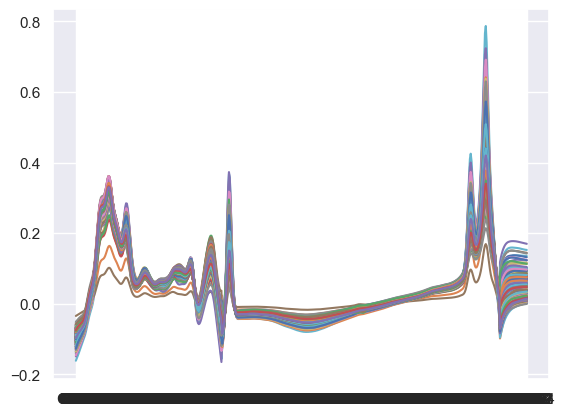

In [3]:
for i in range(MIRS_no_water_transform.shape[0]):
    plt.plot(MIRS_no_water_transform.iloc[i, :])
plt.show()

In [4]:
traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

describe_table = dict()
for trait in traits:
    describe_table.update([(trait,remove_outliers(pd.DataFrame(features_red.loc[features_red.loc[:,trait] != 0, trait]), [trait],3).describe().values.reshape((8)))])

pd.DataFrame(describe_table, index = ["Count", 'Mean', "SD", "Min", '25%', '50%', '75%', 'Max']).T.round(2)

,Count,Mean,SD,Min,25%,50%,75%,Max
RCT,484.0,20.77,8.79,1.75,14.50,19.62,26.25,47.50
k20,449.0,5.97,3.57,1.25,3.25,5.00,7.75,18.00
a30,421.0,30.59,16.07,0.02,19.16,30.64,42.68,74.90
a60,480.0,31.01,11.29,1.76,23.40,29.24,37.46,66.34
Casein_micelle_size,585.0,186.92,76.21,63.12,156.05,170.80,192.80,968.60
Native_pH,596.0,6.68,0.10,6.34,6.61,6.67,6.75,6.97
Heat_stability,422.0,8.84,6.14,0.58,4.18,6.76,11.43,28.22
Urea_Content,600.0,26.07,15.01,-0.80,14.10,23.85,36.52,66.50
Fat_content,597.0,4.72,1.09,1.62,3.97,4.62,5.37,8.42
Lactose_content,600.0,4.62,0.24,3.90,4.46,4.61,4.78,5.28


## Analyze Scaling Descriptors (Wavelet Features) for 'Significance'

Significant Wavelet Features are those whose categorical KDE's reject the Null Hypothesis of a Two Sample-Two Sided Kolmogorov–Smirnov Test. For 4 level categorical data, we keep the Wavelet Features that have at least one significant wavelet feature when comparing 'q1 v q2','q1 v q3','q1 v q4','q2 v q3','q2 v q4', and 'q3 v q4'. Ordered significance is then sorting the p-values (or average p-value in the case of 4 level categorical data) from least to greatest

In [5]:
wavelet_features = ['slope', 'Spectral Mode', 'LS', 'RS', 'LT', 'RT', 'B', 'pt L', 'pt R', 'max curv','k', 'k_central']
# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]
pval_cutoff = .05
significant_wavelet_features = dict.fromkeys([trait for trait in traits])

for trait in traits:
    y = features_red.loc[:,[trait]] 
    y = y.dropna()
    y = y[y[trait] != 0]
    y = remove_outliers(y, [trait], 3)[trait]
    sig_feat = []
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
        y_cat = pd.qcut(y,q = [0,.5,1], labels = ['Q Low', 'Q High'])
    if trait in protein_traits+["Protein_content"]:
        y_cat = pd.qcut(y,q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])

    kde_data = pd.concat([dataset_red.iloc[y_cat.index.tolist()], y_cat], axis= 1)
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
    
        for feat in wavelet_features:
            low = kde_data[y_cat == 'Q Low'][feat]
            high = kde_data[y_cat == 'Q High'][feat]
            if stats.kstest(low, high).pvalue <= pval_cutoff:
                sig_feat.append([feat,stats.kstest(low, high).pvalue])

    if trait in protein_traits+["Protein_content"]:
        for feat in wavelet_features:
            q1 = kde_data[y_cat == 'Q1'][feat]
            q2 = kde_data[y_cat == 'Q2'][feat]
            q3 = kde_data[y_cat == 'Q3'][feat]
            q4 = kde_data[y_cat == 'Q4'][feat]
            pvals = [stats.kstest(q1, q2).pvalue,
                     stats.kstest(q1, q3).pvalue,
                     stats.kstest(q1, q4).pvalue,
                     stats.kstest(q2, q3).pvalue,
                     stats.kstest(q2, q4).pvalue,
                     stats.kstest(q3, q4).pvalue]
            if any(np.array(pvals) <= pval_cutoff):
                sig_feat.append([feat]+[i for i in pvals])
    if len(sig_feat) == 0:
        continue
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
        significant_wavelet_features[trait] = pd.DataFrame(np.array(sig_feat)[:,1], index = np.array(sig_feat)[:,0], columns=['p-value'])
    if trait in protein_traits+["Protein_content"]:
        col_names = ['q1 v q2','q1 v q3','q1 v q4','q2 v q3','q2 v q4','q3 v q4']
        significant_wavelet_features[trait] = pd.DataFrame(np.array(sig_feat)[:,1:7], index = np.array(sig_feat)[:,0], columns= col_names)



In [6]:
wavelet_features = ['slope', 'Spectral Mode', 'LS', 'RS', 'LT', 'RT', 'B', 'pt L', 'pt R', 'max curv','k', 'k_central']
traits = tech_traits+protein_traits+['Lactose_content', 'Urea_Content', 'Fat_content', 'Protein_content']
wavelet_features_ordered_significance = dict.fromkeys([trait for trait in traits])

for trait in traits:
    y = features_red.loc[:,[trait]] 
    y = y.dropna()
    y = y[y[trait] != 0]
    y = remove_outliers(y, [trait], 3)[trait]
    sig_feat = []
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
        y_cat = pd.qcut(y,q = [0,.5,1], labels = ['Q Low', 'Q High'])
    if trait in protein_traits+["Protein_content"]:
        y_cat = pd.qcut(y,q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])

    kde_data = pd.concat([dataset_red.iloc[y_cat.index.tolist()], y_cat], axis= 1)
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
    
        for feat in wavelet_features:
            low = kde_data[y_cat == 'Q Low'][feat]
            high = kde_data[y_cat == 'Q High'][feat]
            sig_feat.append([feat,float(stats.kstest(low, high).pvalue)])

    if trait in protein_traits+["Protein_content"]:
        for feat in wavelet_features:
            q1 = kde_data[y_cat == 'Q1'][feat]
            q2 = kde_data[y_cat == 'Q2'][feat]
            q3 = kde_data[y_cat == 'Q3'][feat]
            q4 = kde_data[y_cat == 'Q4'][feat]
            pvals = [float(stats.kstest(q1, q2).pvalue),
                     float(stats.kstest(q1, q3).pvalue),
                     float(stats.kstest(q1, q4).pvalue),
                     float(stats.kstest(q2, q3).pvalue),
                     float(stats.kstest(q2, q4).pvalue),
                     float(stats.kstest(q3, q4).pvalue)]
            sig_feat.append([feat]+[p for p in pvals])
            
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
        wavelet_features_ordered_significance[trait] = pd.DataFrame(np.array(sig_feat)[:,1], index = np.array(sig_feat)[:,0], columns=['p-value']).astype('float64')
    if trait in protein_traits+["Protein_content"]:
        col_names = ['q1 v q2','q1 v q3','q1 v q4','q2 v q3','q2 v q4','q3 v q4']
        wavelet_features_ordered_significance[trait] = pd.DataFrame(np.array(sig_feat)[:,1:7], index = np.array(sig_feat)[:,0], columns= col_names).astype('float64')

In [7]:
for trait in traits:
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
        wavelet_features_ordered_significance[trait] = wavelet_features_ordered_significance[trait].sort_values(by = 'p-value')
    if trait in protein_traits+["Protein_content"]:
        # Sorting Features by average p-value
        wavelet_features_ordered_significance[trait]['mean p-value'] = wavelet_features_ordered_significance[trait].loc[:, col_names].mean(axis = 1)
        wavelet_features_ordered_significance[trait] = wavelet_features_ordered_significance[trait].sort_values(by = 'mean p-value')
        wavelet_features_ordered_significance[trait] = wavelet_features_ordered_significance[trait].drop(columns = ['mean p-value'])

### Example of 'Significant Wavelet Features' and Wavelet Features in 'Ordered Significance'

In [8]:
wavelet_features_ordered_significance['Lactose_content']

,p-value
max curv,5.476629e-26
k_central,1.326192e-25
LS,2.164973e-21
B,2.940671e-21
RS,7.122979e-18
pt R,1.932093e-14
pt L,2.549251e-07
RT,1.907323e-03
k,4.975434e-03
Spectral Mode,1.012928e-02


In [9]:
significant_wavelet_features['Lactose_content']

,p-value
Spectral Mode,0.010129279363345402
LS,2.1649726879175454e-21
RS,7.122979032607161e-18
RT,0.0019073232995063672
B,2.940671086745086e-21
pt L,2.549251274009517e-07
pt R,1.9320933224260713e-14
max curv,5.476628812894387e-26
k,0.004975434152248248
k_central,1.3261921620779173e-25


## Generate KDE Plots

In [10]:
# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]
# for trait in traits:
#     y = features_red.loc[:,[trait]] 
#     y = y.dropna()
#     y = y[y[trait] != 0]
#     y = remove_outliers(y, [trait], 3)[trait]
#     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#         y_cat = pd.qcut(y,q = [0,.5,1], labels = ['Q Low', 'Q High'])
#     if trait in protein_traits+["Protein_content"]:
#         y_cat = pd.qcut(y,q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])
#     kde_data = pd.concat([dataset_red.iloc[y_cat.index.tolist()], y_cat], axis= 1)
#     kde_data.columns = ['slope', 'Spectral Mode', 'LS', 'RS', 'LT', 'RT', 'B', 'pt L', 'pt R','max curv', 'k', 'k_central', trait]    
#     fig, axes = plt.subplots(3, 4, figsize=(18, 10))
#     fig.suptitle(milk_traits_rename[trait]+' KDE Plots')

#     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#         sns.kdeplot(ax = axes[0,0],data=kde_data, x= 'slope', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['slope'].values)))
#         axes[0,0].set(xlabel = wavelet_features_rename['slope'])
#         sns.kdeplot(ax = axes[0,1],data=kde_data, x='Spectral Mode', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['Spectral Mode'].values)))
#         axes[0,1].set(xlabel = wavelet_features_rename['Spectral Mode'])
#         sns.kdeplot(ax = axes[0,2],data=kde_data, x='LS', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['LS'].values)))
#         axes[0,2].set(xlabel = wavelet_features_rename['LS'])
#         sns.kdeplot(ax = axes[0,3],data=kde_data, x='RS', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['RS'].values)))
#         axes[0,3].set(xlabel = wavelet_features_rename['RS'])
#         sns.kdeplot(ax = axes[1,0],data=kde_data, x='LT', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['LT'].values)))
#         axes[1,0].set(xlabel = wavelet_features_rename['LT'])
#         sns.kdeplot(ax = axes[1,1],data=kde_data, x='RT', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['RT'].values)))
#         axes[1,1].set(xlabel = wavelet_features_rename['RT'])
#         sns.kdeplot(ax = axes[1,2],data=kde_data, x='B', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['B'].values)))
#         axes[1,2].set(xlabel = wavelet_features_rename['B'])
#         sns.kdeplot(ax = axes[1,3],data=kde_data, x='pt L', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['pt L'].values)))
#         axes[1,3].set(xlabel = wavelet_features_rename['pt L'])
#         sns.kdeplot(ax = axes[2,0],data=kde_data, x='pt R', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['pt R'].values)))
#         axes[2,0].set(xlabel = wavelet_features_rename['pt R'])
#         sns.kdeplot(ax = axes[2,1],data=kde_data, x='max curv', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['max curv'].values)))
#         axes[2,1].set(xlabel = wavelet_features_rename['max curv'])
#         sns.kdeplot(ax = axes[2,2],data=kde_data, x='k', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['k'].values)))
#         axes[2,2].set(xlabel = wavelet_features_rename['k'])
#         sns.kdeplot(ax = axes[2,3],data=kde_data, x='k_central', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['k_central'].values)))
#         axes[2,3].set(xlabel = wavelet_features_rename['k_central'])
#         fig.tight_layout()
#         plt.savefig("KDE_Plots/"+trait+"_KDE_2_Quantiles.png")
#         plt.close()
#     if trait in protein_traits+["Protein_content"]:
#         sns.kdeplot(ax = axes[0,0],data=kde_data, x= 'slope', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['slope'].values)))
#         axes[0,0].set(xlabel = wavelet_features_rename['slope'])
#         sns.kdeplot(ax = axes[0,1],data=kde_data, x='Spectral Mode', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['Spectral Mode'].values)))
#         axes[0,1].set(xlabel = wavelet_features_rename['Spectral Mode'])
#         sns.kdeplot(ax = axes[0,2],data=kde_data, x='LS', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['LS'].values)))
#         axes[0,2].set(xlabel = wavelet_features_rename['LS'])
#         sns.kdeplot(ax = axes[0,3],data=kde_data, x='RS', fill=True, hue=y_cat,warn_singular=False)
#         axes[0,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['RS'].values)))
#         axes[0,3].set(xlabel = wavelet_features_rename['RS'])
#         sns.kdeplot(ax = axes[1,0],data=kde_data, x='LT', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['LT'].values)))
#         axes[1,0].set(xlabel = wavelet_features_rename['LT'])
#         sns.kdeplot(ax = axes[1,1],data=kde_data, x='RT', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['RT'].values)))
#         axes[1,1].set(xlabel = wavelet_features_rename['RT'])
#         sns.kdeplot(ax = axes[1,2],data=kde_data, x='B', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['B'].values)))
#         axes[1,2].set(xlabel = wavelet_features_rename['B'])
#         sns.kdeplot(ax = axes[1,3],data=kde_data, x='pt L', fill=True, hue=y_cat,warn_singular=False)
#         axes[1,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['pt L'].values)))
#         axes[1,3].set(xlabel = wavelet_features_rename['pt L'])
#         sns.kdeplot(ax = axes[2,0],data=kde_data, x='pt R', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['pt R'].values)))
#         axes[2,0].set(xlabel = wavelet_features_rename['pt R'])
#         sns.kdeplot(ax = axes[2,1],data=kde_data, x='max curv', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['max curv'].values)))
#         axes[2,1].set(xlabel = wavelet_features_rename['max curv'])
#         sns.kdeplot(ax = axes[2,2],data=kde_data, x='k', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['k'].values)))
#         axes[2,2].set(xlabel = wavelet_features_rename['k'])
#         sns.kdeplot(ax = axes[2,3],data=kde_data, x='k_central', fill=True, hue=y_cat,warn_singular=False)
#         axes[2,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['k_central'].values)))
#         axes[2,3].set(xlabel = wavelet_features_rename['k_central'])
#         fig.tight_layout()
#         plt.savefig("KDE_Plots/"+trait+"_KDE_4_Quantiles.png")
#         plt.close()

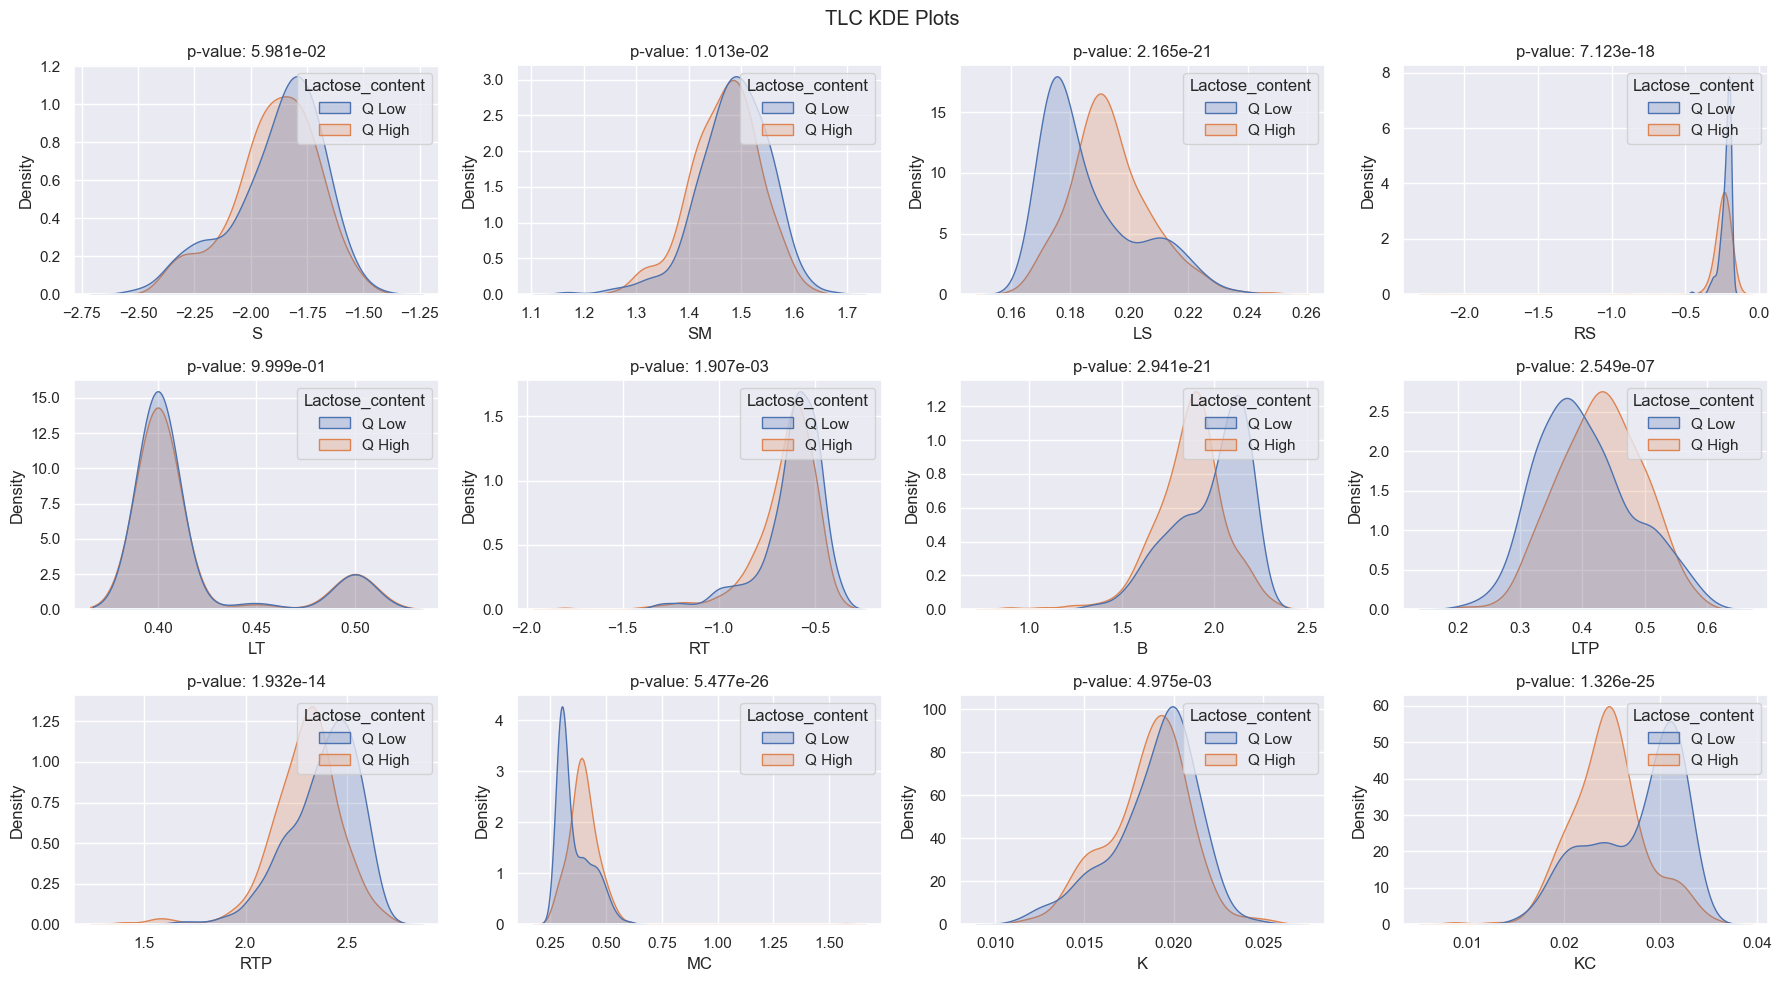

In [11]:
 for trait in ["Lactose_content"]:
    y = features_red.loc[:,[trait]] 
    y = y.dropna()
    y = y[y[trait] != 0]
    y = remove_outliers(y, [trait], 3)[trait]
    if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
        y_cat = pd.qcut(y,q = [0,.5,1], labels = ['Q Low', 'Q High'])
    if trait in protein_traits+["Protein_content"]:
        y_cat = pd.qcut(y,q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])
    kde_data = pd.concat([dataset_red.iloc[y_cat.index.tolist()], y_cat], axis= 1)
    kde_data.columns = ['slope', 'Spectral Mode', 'LS', 'RS', 'LT', 'RT', 'B', 'pt L', 'pt R','max curv', 'k', 'k_central', trait]    
    fig, axes = plt.subplots(3, 4, figsize=(18, 10))
    fig.suptitle(milk_traits_rename[trait]+' KDE Plots')
    sns.kdeplot(ax = axes[0,0],data=kde_data, x= 'slope', fill=True, hue=y_cat,warn_singular=False)
    axes[0,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['slope'].values)))
    axes[0,0].set(xlabel = wavelet_features_rename['slope'])
    sns.kdeplot(ax = axes[0,1],data=kde_data, x='Spectral Mode', fill=True, hue=y_cat,warn_singular=False)
    axes[0,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['Spectral Mode'].values)))
    axes[0,1].set(xlabel = wavelet_features_rename['Spectral Mode'])
    sns.kdeplot(ax = axes[0,2],data=kde_data, x='LS', fill=True, hue=y_cat,warn_singular=False)
    axes[0,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['LS'].values)))
    axes[0,2].set(xlabel = wavelet_features_rename['LS'])
    sns.kdeplot(ax = axes[0,3],data=kde_data, x='RS', fill=True, hue=y_cat,warn_singular=False)
    axes[0,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['RS'].values)))
    axes[0,3].set(xlabel = wavelet_features_rename['RS'])
    sns.kdeplot(ax = axes[1,0],data=kde_data, x='LT', fill=True, hue=y_cat,warn_singular=False)
    axes[1,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['LT'].values)))
    axes[1,0].set(xlabel = wavelet_features_rename['LT'])
    sns.kdeplot(ax = axes[1,1],data=kde_data, x='RT', fill=True, hue=y_cat,warn_singular=False)
    axes[1,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['RT'].values)))
    axes[1,1].set(xlabel = wavelet_features_rename['RT'])
    sns.kdeplot(ax = axes[1,2],data=kde_data, x='B', fill=True, hue=y_cat,warn_singular=False)
    axes[1,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['B'].values)))
    axes[1,2].set(xlabel = wavelet_features_rename['B'])
    sns.kdeplot(ax = axes[1,3],data=kde_data, x='pt L', fill=True, hue=y_cat,warn_singular=False)
    axes[1,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['pt L'].values)))
    axes[1,3].set(xlabel = wavelet_features_rename['pt L'])
    sns.kdeplot(ax = axes[2,0],data=kde_data, x='pt R', fill=True, hue=y_cat,warn_singular=False)
    axes[2,0].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['pt R'].values)))
    axes[2,0].set(xlabel = wavelet_features_rename['pt R'])
    sns.kdeplot(ax = axes[2,1],data=kde_data, x='max curv', fill=True, hue=y_cat,warn_singular=False)
    axes[2,1].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['max curv'].values)))
    axes[2,1].set(xlabel = wavelet_features_rename['max curv'])
    sns.kdeplot(ax = axes[2,2],data=kde_data, x='k', fill=True, hue=y_cat,warn_singular=False)
    axes[2,2].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['k'].values)))
    axes[2,2].set(xlabel = wavelet_features_rename['k'])
    sns.kdeplot(ax = axes[2,3],data=kde_data, x='k_central', fill=True, hue=y_cat,warn_singular=False)
    axes[2,3].set_title('p-value: '+"{:.3e}".format(np.mean(wavelet_features_ordered_significance[trait].loc['k_central'].values)))
    axes[2,3].set(xlabel = wavelet_features_rename['k_central'])
    fig.tight_layout()

## Define Classification Models, Tuning Parameter Space, and Objective Functions for Bayesian Optimization

In [12]:
classifiers = ['SVM', 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']

space_dict = dict.fromkeys([classifier for classifier in classifiers])

In [13]:
space_dict['SVM'] = {
                    'C': hp.lognormal('C', 0, 1), # Distribution of tuning parameter space
                    'kernel': hp.choice('kernel',['linear','rbf']),
                    'gamma': hp.uniform('gamma', 0, 1)
            }

space_dict['LDA'] = {
                    'shrinkage': hp.uniform('shrinkage', 0, 1),
            }

space_dict['GBM'] = {
                    'max_depth': hp.randint('max_depth', 1, 10),
                    'learning_rate': hp.uniform('learning_rate',0, 1),
                    'n_estimators': hp.randint('n_estimators', 1,251),
                    'subsample': hp.uniform('subsample', 0,1), # Not sure if subsampling adheres to stratification
            }

space_dict['KNN'] = {
                    'n_neighbors': hp.randint('n_neighbors',1, 15),
                    'p': hp.choice('p',[1,2]),
                    'weights': hp.choice('weights', ['uniform', 'distance']),
            }

space_dict['Logit'] = {
                    'l1_ratio': hp.uniform('l1_ratio', 0, 1),
                    'C': hp.lognormal('C',0, 1)
            }

In [14]:
def svc_bo(params):
    params = {
        'C': params['C'],
        'kernel': params['kernel'],
        'gamma': params['gamma']
                }
    # Define classification model using parameters
    svc_model = svm.SVC(**params) 
    
    # We want to find parameters that maximize the average cross validation accuracy over the training set
    # cv_split = StratifiedKFold(n_splits = 10)
    # Accuracy is minimized so procedure is same for 2 class and 4 class problems
    best_score = cross_val_score(svc_model, X_train, y_train, scoring='accuracy', cv=cv_split, n_jobs = -1).mean()
    return 1 - best_score # Returns 1 - best_score so we have something to minimize

def lda_bo(params):
    params = {
        'shrinkage': params['shrinkage'],
            }
    lda_model = DA.LinearDiscriminantAnalysis(shrinkage=params['shrinkage'], solver = 'eigen')
    best_score = cross_val_score(lda_model, X_train, y_train, scoring='accuracy', cv= cv_split, n_jobs = -1).mean()
    return 1 - best_score

def gbm_cl_bo2(params):
    params = {
        'max_depth':params['max_depth'],
        'learning_rate': params['learning_rate'],
        'n_estimators': params['n_estimators'],
        'subsample': params['subsample']
                }
    gbm_bo2 = GradientBoostingClassifier(**params)
    best_score = cross_val_score(gbm_bo2, X_train, y_train, scoring='accuracy', cv=cv_split, n_jobs = -1).mean()
    return 1 - best_score

def knn_cl_bo2(params):
    params = {
        'n_neighbors': params['n_neighbors'],
        'p': params['p'],
        'weights': params['weights']
                }
    knn_bo2 = KNeighborsClassifier(**params)
    best_score = cross_val_score(knn_bo2, X_train, y_train, scoring='accuracy', cv=cv_split, n_jobs = -1).mean()
    return 1 - best_score

def logit_cl_bo2(params):
    params = {
        'l1_ratio':params['l1_ratio'],
        'C': params['C'],   
            }
    # Elastic Net Penalty is a convex combination of l1 and l2 penalty, no tuning needed for 'penalty' parameter
    logit_bo2 = LogisticRegression(l1_ratio = params['l1_ratio'], C = params['C'], penalty = 'elasticnet', solver = 'saga', max_iter = 15000)
    best_score = cross_val_score(logit_bo2, X_train, y_train, scoring='accuracy', cv=cv_split, n_jobs = -1).mean()
    return 1 - best_score



## Implement Classification Models Using Only Wavelet Features

In [15]:
# # Define traits that we are interested in modeling/predicting
# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# # Define Classificaion Models we're implementing
# classifiers = ['SVM', 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']

# nreps = 4  # Number of times to repeat procedure for std. and average accuracy scores

# # Number of Wavelet Features to include in model in order of significance
# num_sig_wavelet_feat = [i for i in range(1,len(wavelet_features) + 1)]

# max_bo_evals = 20 # Number of Iterations used in bayesian optimization of tuning parameters

# # Create dictionary to store results
# test_results_dict = dict.fromkeys([(trait,classifier,acc) for trait in traits for classifier in classifiers for acc in ['Training_Accuracy_mean', 'Training_Accuracy_std', 'Testing_Accuracy_mean', 'Testing_Accuracy_std']], [])
# classifier_results_dict = dict.fromkeys([(classifier,trait,num) for classifier in classifiers for trait in traits for num in num_sig_wavelet_feat], [])

# classifier_count = 1 # For progress bar

# # Iterate procedure over classification models
# for classifier in classifiers:
#     i = 0 # For progress bar
    
#     # Iterate procedure over traits
#     for trait in traits:
#         j = 0# For progress bar
#         update_progress(i/len(traits), str(classifier_count)+'/'+str(len(classifiers)))# For progress bar
        
#          # For storing results
#         training_accs = [] 
#         training_stds = []
#         testing_accs = []
#         testing_stds = []
        
#         # Iterate procedure over Number of Signicant Wavelet Features to implement in order of significance
#         for num in num_sig_wavelet_feat:
#             k = 0# For progress bar
            
#              # For storing results
#             temp_training_accs = []
#             temp_testing_accs = []
#             temp_model_list = []
            
#             # Repeat procedure to get a mean and standard deviation
#             for count in range(nreps):
#                 if classifier != 'PLSDA': # PLSDA model has to be performed a little differently
                    
#                     y = features_red.loc[:,[trait]] # Define y
#                     y = y.dropna() # Drop NA values
#                     y = y[y[trait] != 0] # Drop 0 Values
#                     y = remove_outliers(y, [trait], 3) # Drop values greater than 3 standard deviations from mean

#                     # Consider transforming y data so that it follows a Normal Distribution
#                     #index = y.index
#                     #y = pd.Series(stats.yeojohnson(y)[0].T[0::-1][0], index = index, name = trait)

#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.5,1], labels = ['Q Low', 'Q High'])
#                     if trait in protein_traits+["Protein_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])

#                     # Get the significant wavelet features corresponding to the trait and number of significant features
#                     sig_feat = wavelet_features_ordered_significance[trait].index.tolist()[0:num]
#                     dataset_red_temp = dataset_red.loc[y_cat.index.tolist()] # Get the appropriate  observations from Wavelet Features
#                     dataset_red_temp = dataset_red_temp[sig_feat] # Extract appropriate wavelet features


#                     # Define X
#                     X = dataset_red_temp
                    
                    
#                     # Define a Train-Test split, stratified to the categorical response variable 'y_cat'. 
#                     # %20 test_size is used since our lowest obersvation count is 421. 
#                     # With 80% data going into training, and a 10-fold cv split, at least 302 observations are used to build ...
#                     # ... a model at any given time
#                     # New training and testing data is done with each procedure repition 'nreps'
#                     X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .2, stratify = y_cat)
                    
#                     # Some Models require/recommend/'occasionally improve with' feature scaling
#                     if classifier == 'KNN' or classifier == 'SVM' or classifier == 'Logit': 
#                         train_scaler = StandardScaler()
#                         test_scaler = StandardScaler()
            
#                         X_train = train_scaler.fit_transform(X_train)
#                         X_test = test_scaler.fit_transform(X_test)

#                     # Retrieve appropriate tuning parameter space
#                     space = space_dict[classifier]
                    
#                     # Tune classification model and fit
#                     if classifier == 'SVM':
#                         best_param = fmin(fn=svc_bo,  # Function to minimize
#                                         space=space, # Space to minimize over
#                                         max_evals=max_bo_evals, # Maximum iterations of function
#                                         algo=tpe.suggest, # Run suggested algorithm
#                                         verbose = 0) # No intermediate output
                        
#                         # Define the best parameters as the ones found by the hyperopt function 'fmin'
#                         model = svm.SVC(C = best_param['C'], gamma = best_param['gamma'], kernel = ['linear', 'rbf'][best_param['kernel']])
                        
#                         #final training of model
#                         model.fit(X_train, y_train) 

#                     if classifier == 'LDA':
#                         best_param = fmin(fn=lda_bo,
#                                         space=space,
#                                         max_evals=max_bo_evals,
#                                         algo=tpe.suggest,
#                                         verbose = 0)

#                         model = DA.LinearDiscriminantAnalysis(shrinkage=best_param['shrinkage'], solver = 'eigen')
#                         model.fit(X_train, y_train)
#                     if classifier == 'GBM':
#                         gbm_best_param = fmin(fn=gbm_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)
#                         model = GradientBoostingClassifier(**gbm_best_param)
#                         model.fit(X_train, y_train)

#                     if classifier == 'KNN':
#                         knn_best_param = fmin(fn=knn_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)

#                         model = KNeighborsClassifier(weights = ['uniform', 'distance'][knn_best_param['weights']], n_neighbors = knn_best_param['n_neighbors'], p = [1, 2][knn_best_param['p']], n_jobs= -1)
#                         model.fit(X_train, y_train)

#                     if classifier == 'Logit':
#                         logit_best_param = fmin(fn=logit_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)

#                         model = LogisticRegression(l1_ratio = logit_best_param['l1_ratio'], C = logit_best_param['C'], penalty = 'elasticnet', solver = 'saga', max_iter = 15000)
#                         model.fit(X_train, y_train)

#                     if classifier == 'GNB':
#                         model = GaussianNB()
#                         model.fit(X_train, y_train)

#                     if classifier == 'QDA':
#                         model = DA.QuadraticDiscriminantAnalysis()
#                         model.fit(X_train, y_train)

#                     # Store Training and Testing accuracy
#                     temp_training_accs.append(accuracy_score(y_train, model.predict(X_train))) 
#                     temp_testing_accs.append(accuracy_score(y_test, model.predict(X_test)))
#                     temp_model_list.append(model)
                    
#                 if classifier == 'PLSDA':
#                     y = features_red.loc[:,[trait]] 
#                     y = y.dropna()
#                     y = y[y[trait] != 0]
#                     y = remove_outliers(y, [trait], 3)
#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.5,1], labels = [0, 1])
#                     if trait in protein_traits+["Protein_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3','Q4'])
#                         y_cat = pd.get_dummies(y_cat) # Convert 4 level categorical variable into one hot encoded vector
                
#                     dataset_red_temp = dataset_red.loc[y_cat.index.tolist()] # Get the appropriate  observations from Wavelet Features
                            
#                     # Define X
#                     X = dataset_red_temp

                    
#                     X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .2, stratify = y_cat)
#                     # num is now instead number of latent variables in X-scores
#                     model = PLSRegression(n_components = num) 
#                     model.fit(X_train,y_train)
#                     yhat_test = model.predict(X_test)
#                     yhat_train = model.predict(X_train)
            
#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         # Convert predicted probability into categorical variable
#                         # .5 is used because other similar predictive models were not able to adjust this. 
                
#                         yhat_test_cat = pd.Series((yhat_test > .5).astype('uint8').flatten())
#                         yhat_train_cat = pd.Series((yhat_train > .5).astype('uint8').flatten())

#                     if trait in protein_traits+["Protein_content"]:
#                         # Convert predicted probabilities into categorical variable
#                         temp_mat = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
#                         yhat_test_cat = [temp_mat[np.argmax(yhat_test[idx])] for idx in range(yhat_test.shape[0])]
#                         yhat_train_cat = [temp_mat[np.argmax(yhat_train[idx])] for idx in range(yhat_train.shape[0])]
                    
#                     # Store Training and Testing accuracy
#                     temp_training_accs.append(accuracy_score(y_train, yhat_train_cat))
#                     temp_testing_accs.append(accuracy_score(y_test, yhat_test_cat))
                
#                 # For progress bar
#                 k += 1
#                 update_progress((i + ((j + ((k)/(nreps)))/(len(num_sig_wavelet_feat))))/(len(traits)), str(classifier_count)+'/'+str(len(classifiers)))
            
#             # Store the mean and standard deviation of Training Accuracy and Testing Accuracy after...
#             # ...'nreps' repitions of procedure
#             training_accs.append(np.array(temp_training_accs).mean())
#             training_stds.append(np.array(temp_training_accs).std())
#             testing_accs.append(np.array(temp_testing_accs).mean())
#             testing_stds.append(np.array(temp_testing_accs).std())
#             classifier_results_dict[classifier,trait,num] = temp_model_list

#             j += 1 # For progress bar
            
#         # Store mean and standard deviation of 'nreps' many training & testing accuracies of the given trait and classifier
#         test_results_dict[trait,classifier,'Training_Accuracy_mean'] = training_accs
#         test_results_dict[trait,classifier,'Training_Accuracy_std'] = training_stds
#         test_results_dict[trait,classifier,'Testing_Accuracy_mean'] = testing_accs
#         test_results_dict[trait,classifier,'Testing_Accuracy_std'] = testing_stds

#         i += 1# For progress bar
    
#     classifier_count += 1# For progress bar

In [16]:
# ## Save Results
# pickle.dump(test_results_dict, open("PythonResults/Wavelet_Features_models.p", "wb"))
# pickle.dump(classifier_results_dict, open("PythonResults/Wavelet_Features_models_parameters.p", "wb"))

In [17]:
# ## Save Results by classification model
# test_results_dict = pickle.load( open ("PythonResults/Wavelet_Features_models.p","rb"))
# temp = pd.DataFrame(test_results_dict, index = num_sig_wavelet_feat).T
# for classifier in classifiers:
#     pickle.dump(temp.swaplevel(i = 0, j = 1, axis = 0).loc[classifier], open("PythonResults/"+classifier+"_Wavelet_Features_results.p", "wb"))

### Throw out overfitting and underfitting models, report best testing accuracy and simplest model with comparable accuracy

In [18]:
# over_fitting_detect = .04
# under_fitting_detect = 0
# test_acc_interval = .015

# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# keep_idx_dict= dict.fromkeys([(trait, classifier) for trait in traits for classifier in classifiers])
# acceptable_classifiers = []
# best_classifiers_dict = dict.fromkeys([trait for trait in traits ])
# simplest_classifiers = dict.fromkeys([trait for trait in traits])

# temp = pickle.load( open ("PythonResults/Wavelet_Features_models.p","rb"))
# classifier_load_str = "_Wavelet_Features_results.p"
# temp = pd.DataFrame(temp, index = [1,2,3,4,5,6,7,8,9,10,11,12])

# for trait in traits:
#     for classifier in classifiers:
#         bool_series = (temp[trait][classifier]['Training_Accuracy_mean'] - \
#                                   temp[trait][classifier]['Testing_Accuracy_mean'] > over_fitting_detect) | \
#                     (temp[trait][classifier]['Testing_Accuracy_mean'] - temp[trait][classifier]['Training_Accuracy_mean'] > under_fitting_detect)
# #         print(temp[trait][classifier])
# #         print(bool_series)
#         keep_idx = [i for i,val in enumerate(bool_series) if not val]
#         keep_idx_dict[trait,classifier] = keep_idx
        

# for trait in traits:
#     for classifier in classifiers:

#         if not len(keep_idx_dict[trait,classifier]) > 0:
#             continue # All # of predictors of that classifier and trait were overfitting
            
#         temp_dFrame = pickle.load( open ("PythonResults/"+classifier+classifier_load_str, "rb") )
 
#         keep_classifiers = temp_dFrame.loc[trait].iloc[:,keep_idx_dict[trait,classifier]]

#         for i in range(len(keep_idx_dict[trait,classifier])):
#             test_acc_mean, test_acc_std = keep_classifiers.loc['Testing_Accuracy_mean'].iloc[i], keep_classifiers.loc['Testing_Accuracy_std'].iloc[i]
#             train_acc_mean, train_acc_std = keep_classifiers.loc['Training_Accuracy_mean'].iloc[i], keep_classifiers.loc['Training_Accuracy_std'].iloc[i]
#             num_predictor = int(keep_classifiers.iloc[:,i].name)
#             acceptable_classifiers.append([trait, classifier, train_acc_mean, train_acc_std, test_acc_mean, test_acc_std, num_predictor])
        

# # Simplest Non-over/under fitting models comparable to the best model of that trait and classifier
# # Each trait reports mode

# # Data frame only containing non-over/under fitting models
# acceptable_classifiers = pd.DataFrame(acceptable_classifiers, columns = ['Trait','Classifier','Training Accuracy','Std. Training Accuracy','Testing Accuracy', 'Std. Testing Accuracy', '# Predictors used in Training']).set_index(['Trait','Classifier'])

# for trait in traits:
# #     print(temp_dFrame2.loc[trait])
    
#     # Again find the max testing accuracy now that no classifiers are under/over fitting
#     argmax_testing_acc = acceptable_classifiers.loc[trait]['Testing Accuracy'].argmax()
#     best_classifiers_dict[trait] = [acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].name]+[val for val in acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].values[:-1]]+[int(acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].values[-1])]
#     best_test_acc = acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].loc['Testing Accuracy']
#     # Find classifiers within test_acc_interval of best test acc
#     acceptable_idx = acceptable_classifiers.loc[trait]['Testing Accuracy'].between(best_test_acc - test_acc_interval, best_test_acc + test_acc_interval).values
#     temp_dFrame2 = acceptable_classifiers.loc[trait].iloc[acceptable_idx]
#     min_predictors = temp_dFrame2['# Predictors used in Training'].min()

#     notNone_idx = temp_dFrame2['# Predictors used in Training'].values != None

#     min_predictors_idx = (temp_dFrame2.iloc[notNone_idx]['# Predictors used in Training'] == min_predictors).values
#     temp_dFrame3 = temp_dFrame2.iloc[notNone_idx].iloc[min_predictors_idx]
    
#     # Cannot take argmax again
#     argmax_testing_accuracy = [i for i,val in \
#                 enumerate(temp_dFrame3['Testing Accuracy'] \
#                           == temp_dFrame3['Testing Accuracy'].max()) if val]
#     if len(argmax_testing_accuracy) < 1:
#         print("All (non-over/under fitting) classifiers for trait "+trait+" were not within a threshold of "+str(test_acc_interval)+" of the maximum testing accuracy\n (over_fitting_detect = "+str(over_fitting_detect)+")")
#         continue
        
#     if len(argmax_testing_accuracy) > 1:
#         temp_dFrame4 = temp_dFrame3.iloc[argmax_testing_accuracy,:]# Break ties with minimum std testing accuracy

#         argmin_testing_std = [i for i,val in \
#                 enumerate(temp_dFrame4['Std. Testing Accuracy'] \
#                           == temp_dFrame4['Std. Testing Accuracy'].min()) if val]
#         simplest_classifiers[trait] = [temp_dFrame4.iloc[argmin_testing_std,:].index[0]]+ [temp_dFrame4.iloc[argmin_testing_std,:].values[0][i] for i in range(4)]+[int(min_predictors)]
#         continue
#     simplest_classifiers[trait] = [temp_dFrame3.iloc[argmax_testing_accuracy,:].index[0]]+[temp_dFrame3.iloc[argmax_testing_accuracy,:].values[0][i] for i in range(4)]+[int(min_predictors)]

In [19]:
# Highest_Testing_Accuracy_Wavelet_Features = pd.DataFrame(best_classifiers_dict, index = ['Model', 'Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy', '# Predictors Used in Training']).T

In [20]:
# Simplest_Comparable_Testing_Accuracy_Wavelet_Features = pd.DataFrame(simplest_classifiers, index = ['Model', 'Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy', '# Predictors Used in Training']).T

In [21]:
# # Save table storing test/train accuracy
# pickle.dump(Highest_Testing_Accuracy_Wavelet_Features,
#             open("PythonResults/Highest_Testing_Accuracy_Wavelet_Features", "wb"))

In [22]:
# # Save table storing test/train accuracy
# pickle.dump(Simplest_Comparable_Testing_Accuracy_Wavelet_Features,
#             open("PythonResults/Simplest_Comparable_Testing_Accuracy_Wavelet_Features", "wb"))

In [23]:
Simplest_Comparable_Testing_Accuracy_Wavelet_Features = pickle.load(open("PythonResults/Simplest_Comparable_Testing_Accuracy_Wavelet_Features", "rb"))
Highest_Testing_Accuracy_Wavelet_Features = pickle.load(open("PythonResults/Highest_Testing_Accuracy_Wavelet_Features", "rb"))

In [24]:
Highest_Testing_Accuracy_Wavelet_Features

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,SVM,0.694444,0.039289,0.690722,0.010309,12
k20,SVM,0.720752,0.016523,0.697222,0.036324,4
a30,PLSDA,0.726935,0.00973,0.705882,0.02201,9
a60,SVM,0.68099,0.009479,0.679688,0.029806,3
Casein_micelle_size,Logit,0.558226,0.016299,0.555556,0.062807,4
Native_pH,SVM,0.704307,0.048076,0.68125,0.033528,10
Heat_stability,SVM,0.732938,0.002098,0.714706,0.021004,10
Urea_Content,SVM,0.778125,0.025281,0.764583,0.038808,7
Fat_content,SVM,0.671908,0.043333,0.670833,0.009317,7
Lactose_content,Logit,0.739583,0.007366,0.739583,0.042236,6


In [25]:
Simplest_Comparable_Testing_Accuracy_Wavelet_Features

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,GBM,0.715762,0.040363,0.685567,0.023622,2
k20,SVM,0.715181,0.003618,0.683333,0.024216,2
a30,Logit,0.708333,0.016437,0.702941,0.026795,5
a60,SVM,0.680339,0.010314,0.677083,0.032106,1
Casein_micelle_size,Logit,0.556624,0.005753,0.553419,0.026602,3
Native_pH,SVM,0.704307,0.048076,0.68125,0.033528,10
Heat_stability,SVM,0.709199,0.007565,0.702941,0.009755,3
Urea_Content,GBM,0.775,0.029646,0.75625,0.025937,4
Fat_content,SVM,0.661426,0.020136,0.658333,0.041248,5
Lactose_content,Logit,0.742188,0.006811,0.729167,0.0125,5


## Implement Classification Models using MIRS data and Wavelet Features

In [26]:
# # Define traits that we are interested in modeling/predicting
# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# # Define Classificaion Models we're implementing
# classifiers = ['SVM', 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']

# nreps = 4  # Number of times to repeat procedure for std. and average accuracy scores

# # Number of PCA components used in decomposing the MIRS data
# pca_comp = [1,2,3,4,5,9,13,17,21]

# max_bo_evals = 20 # Number of Iterations used in bayesian optimization of tuning parameters

# # Create dictionary to store results
# test_results_dict = dict.fromkeys([(trait,classifier,acc) for trait in traits for classifier in classifiers for acc in ['Training_Accuracy_mean', 'Training_Accuracy_std', 'Testing_Accuracy_mean', 'Testing_Accuracy_std']], [])
# classifier_results_dict = dict.fromkeys([(classifier,trait,num) for classifier in classifiers for trait in traits for num in pca_comp], [])

# classifier_count = 1 # For progress bar

# # Iterate procedure over classification models
# for classifier in classifiers:
#     i = 0 # For progress bar
    
#     # Iterate procedure over traits
#     for trait in traits:
#         j = 0# For progress bar
#         update_progress(i/len(traits), str(classifier_count)+'/'+str(len(classifiers)))# For progress bar
        
#          # For storing results
#         training_accs = [] 
#         training_stds = []
#         testing_accs = []
#         testing_stds = []
        
#         # Iterate procedure over Number of Signicant Wavelet Features to implement in order of significance
#         for num in pca_comp:
#             k = 0# For progress bar
            
#              # For storing results
#             temp_training_accs = []
#             temp_testing_accs = []
#             temp_model_list = []
            
#             # Repeat procedure to get a mean and standard deviation
#             for count in range(nreps):
#                 if classifier != 'PLSDA': # PLSDA model has to be performed a little differently
                    
#                     y = features_red.loc[:,[trait]] # Define y
#                     y = y.dropna() # Drop NA values
#                     y = y[y[trait] != 0] # Drop 0 Values
#                     y = remove_outliers(y, [trait], 3) # Drop values greater than 3 standard deviations from mean
#                     pca = PCA(n_components= num) # Define PCA decomposition for MIRS data

#                     # Consider transforming y data so that it follows a Normal Distribution
#                     #index = y.index
#                     #y = pd.Series(stats.yeojohnson(y)[0].T[0::-1][0], index = index, name = trait)

#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.5,1], labels = ['Q Low', 'Q High'])
#                     if trait in protein_traits+["Protein_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])

#                     X = MIRS_scaled.loc[y_cat.index.tolist()] # Get the appropriate MIRS data based on y values kept 

#                     X = pd.DataFrame(pca.fit_transform(X),index = y_cat.index.tolist()) # Get the PCA decomposition of MIRS data and index appropriately
            
#                     sig_feat = significant_wavelet_features[trait].index.tolist() # Get the significant wavelet features corresponding to the trait
#                     dataset_red_temp = dataset_red.loc[y_cat.index.tolist()] # Get the appropriate  observations from Wavelet Features
#                     dataset_red_temp = dataset_red_temp[sig_feat] # Extract only significant wavelet features
            
#                     # Rename Wavelet Features data set columns so they can be joined
#                     dataset_red_temp = dataset_red_temp.set_axis([X.shape[1] + i for i in range(0,len(sig_feat))], axis = 'columns')
                        
#                     # Join the PCA decomposed MIRS data and Wavelet Features.
#                     X = pd.DataFrame(X).join(dataset_red_temp)
                    
#                     # Define a Train-Test split, stratified to the categorical response variable 'y_cat'. 
#                     # %20 test_size is used since our lowest obersvation count is 421. 
#                     # With 80% data going into training, and a 10-fold cv split, at least 302 observations are used to build ...
#                     # ... a model at any given time
#                     # New training and testing data is done with each procedure repition 'nreps'
#                     X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .2, stratify = y_cat)

#                     # Some Models require/recommend/'occasionally improve with' feature scaling
#                     if classifier == 'KNN' or classifier == 'SVM' or classifier == 'Logit': 
#                         train_scaler = StandardScaler()
#                         test_scaler = StandardScaler()
            
#                         X_train = train_scaler.fit_transform(X_train)
#                         X_test = test_scaler.fit_transform(X_test)

#                     # Retrieve appropriate tuning parameter space
#                     space = space_dict[classifier]
                    
#                     # Tune classification model and fit
#                     if classifier == 'SVM':
#                         best_param = fmin(fn=svc_bo,  # Function to minimize
#                                         space=space, # Space to minimize over
#                                         max_evals=max_bo_evals, # Maximum iterations of function
#                                         algo=tpe.suggest, # Run suggested algorithm
#                                         verbose = 0) # No intermediate output
                        
#                         # Define the best parameters as the ones found by the hyperopt function 'fmin'
#                         model = svm.SVC(C = best_param['C'], gamma = best_param['gamma'], kernel = ['linear', 'rbf'][best_param['kernel']])
                        
#                         #final training of model
#                         model.fit(X_train, y_train) 

#                     if classifier == 'LDA':
#                         best_param = fmin(fn=lda_bo,
#                                         space=space,
#                                         max_evals=max_bo_evals,
#                                         algo=tpe.suggest,
#                                         verbose = 0)

#                         model = DA.LinearDiscriminantAnalysis(shrinkage=best_param['shrinkage'], solver = 'eigen')
#                         model.fit(X_train, y_train)
#                     if classifier == 'GBM':
#                         gbm_best_param = fmin(fn=gbm_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)
#                         model = GradientBoostingClassifier(**gbm_best_param)
#                         model.fit(X_train, y_train)

#                     if classifier == 'KNN':
#                         knn_best_param = fmin(fn=knn_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)

#                         model = KNeighborsClassifier(weights = ['uniform', 'distance'][knn_best_param['weights']], n_neighbors = knn_best_param['n_neighbors'], p = [1, 2][knn_best_param['p']], n_jobs= -1)
#                         model.fit(X_train, y_train)

#                     if classifier == 'Logit':
#                         logit_best_param = fmin(fn=logit_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)

#                         model = LogisticRegression(l1_ratio = logit_best_param['l1_ratio'], C = logit_best_param['C'], penalty = 'elasticnet', solver = 'saga', max_iter = 15000)
#                         model.fit(X_train, y_train)

#                     if classifier == 'GNB':
#                         model = GaussianNB()
#                         model.fit(X_train, y_train)

#                     if classifier == 'QDA':
#                         model = DA.QuadraticDiscriminantAnalysis()
#                         model.fit(X_train, y_train)

#                     # Store Training and Testing accuracy
#                     temp_training_accs.append(accuracy_score(y_train, model.predict(X_train))) 
#                     temp_testing_accs.append(accuracy_score(y_test, model.predict(X_test)))
#                     temp_model_list.append(model)
                    
#                 if classifier == 'PLSDA':
#                     y = features_red.loc[:,[trait]] 
#                     y = y.dropna()
#                     y = y[y[trait] != 0]
#                     y = remove_outliers(y, [trait], 3)
#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.5,1], labels = [0, 1])
#                     if trait in protein_traits+["Protein_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3','Q4'])
#                         y_cat = pd.get_dummies(y_cat) # Convert 4 level categorical variable into one hot encoded vector
                        
#                     X = MIRS_scaled.loc[y_cat.index.tolist()]
            
            
#                     sig_feat = significant_wavelet_features[trait].index.tolist()
#                     dataset_red_temp = dataset_red.loc[y_cat.index.tolist()]
#                     dataset_red_temp = dataset_red_temp[sig_feat]
#                     dataset_red_temp = dataset_red_temp.set_axis([X.shape[1] + i for i in range(0,len(sig_feat))], axis = 'columns')
                        
        
#                     X = pd.DataFrame(X).join(dataset_red_temp)
            
#                     X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .2, stratify = y_cat)
                
#                     # num is now instead number of latent variables in X-scores
#                     model = PLSRegression(n_components = num) 
#                     model.fit(X_train,y_train)
#                     yhat_test = model.predict(X_test)
#                     yhat_train = model.predict(X_train)
            
#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         # Convert predicted probability into categorical variable
#                         # .5 is used because other similar predictive models were not able to adjust this. 
                
#                         yhat_test_cat = pd.Series((yhat_test > .5).astype('uint8').flatten())
#                         yhat_train_cat = pd.Series((yhat_train > .5).astype('uint8').flatten())

#                     if trait in protein_traits+["Protein_content"]:
#                         # Convert predicted probabilities into categorical variable
#                         temp_mat = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
#                         yhat_test_cat = [temp_mat[np.argmax(yhat_test[idx])] for idx in range(yhat_test.shape[0])]
#                         yhat_train_cat = [temp_mat[np.argmax(yhat_train[idx])] for idx in range(yhat_train.shape[0])]
                    
#                     # Store Training and Testing accuracy
#                     temp_training_accs.append(accuracy_score(y_train, yhat_train_cat))
#                     temp_testing_accs.append(accuracy_score(y_test, yhat_test_cat))
                
#                 # For progress bar
#                 k += 1
#                 update_progress((i + ((j + ((k)/(nreps)))/(len(pca_comp))))/(len(traits)), str(classifier_count)+'/'+str(len(classifiers)))
            
#             # Store the mean and standard deviation of Training Accuracy and Testing Accuracy after...
#             # ...'nreps' repitions of procedure
#             training_accs.append(np.array(temp_training_accs).mean())
#             training_stds.append(np.array(temp_training_accs).std())
#             testing_accs.append(np.array(temp_testing_accs).mean())
#             testing_stds.append(np.array(temp_testing_accs).std())
#             classifier_results_dict[classifier,trait,num] = temp_model_list

#             j += 1 # For progress bar
            
#         # Store mean and standard deviation of 'nreps' many training & testing accuracies of the given trait and classifier
#         test_results_dict[trait,classifier,'Training_Accuracy_mean'] = training_accs
#         test_results_dict[trait,classifier,'Training_Accuracy_std'] = training_stds
#         test_results_dict[trait,classifier,'Testing_Accuracy_mean'] = testing_accs
#         test_results_dict[trait,classifier,'Testing_Accuracy_std'] = testing_stds

#         i += 1# For progress bar
    
#     classifier_count += 1# For progress bar

In [27]:
# ## Save Results
# pickle.dump(test_results_dict, open("PythonResults/MIRS_and_Wavelet_Features_models.p", "wb"))
# pickle.dump(classifier_results_dict, open("PythonResults/MIRS_and_Wavelet_Features_models_parameters.p", "wb"))

In [28]:
# ## Save Results by classification model
# classifiers = ['SVM', 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']
# test_results_dict = pickle.load( open ("PythonResults/MIRS_and_Wavelet_Features_models.p","rb"))
# temp = pd.DataFrame(test_results_dict, index = pca_comp).T
# for classifier in classifiers:
#     pickle.dump(temp.swaplevel(i = 0, j = 1, axis = 0).loc[classifier], open("PythonResults/"+classifier+"_MIRS_and_Wavelet_Features_results.p", "wb"))

### Throw out overfitting and underfitting models, report best testing accuracy and simplest model with comparable accuracy.

In [29]:
# over_fitting_detect = .04
# under_fitting_detect = 0
# test_acc_interval = .015

# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# keep_idx_dict= dict.fromkeys([(trait, classifier) for trait in traits for classifier in classifiers])
# acceptable_classifiers = []
# best_classifiers_dict = dict.fromkeys([trait for trait in traits ])
# simplest_classifiers = dict.fromkeys([trait for trait in traits])
# pca_comp = [1,2,3,4,5,9,13,17,21]

# temp = pickle.load( open ("PythonResults/MIRS_and_Wavelet_Features_models.p","rb"))
# classifier_load_str = "_MIRS_and_Wavelet_Features_results.p"
# temp = pd.DataFrame(temp, index = pca_comp)

# for trait in traits:
#     for classifier in classifiers:
#         bool_series = (temp[trait][classifier]['Training_Accuracy_mean'] - \
#                                   temp[trait][classifier]['Testing_Accuracy_mean'] > over_fitting_detect) | \
#                     (temp[trait][classifier]['Testing_Accuracy_mean'] - temp[trait][classifier]['Training_Accuracy_mean'] > under_fitting_detect)
# #         print(temp[trait][classifier])
# #         print(bool_series)
#         keep_idx = [i for i,val in enumerate(bool_series) if not val]
#         keep_idx_dict[trait,classifier] = keep_idx
        

# for trait in traits:
#     for classifier in classifiers:

#         if not len(keep_idx_dict[trait,classifier]) > 0:
#             continue # All # of predictors of that classifier and trait were overfitting
            
#         temp_dFrame = pickle.load( open ("PythonResults/"+classifier+classifier_load_str, "rb") )
 
#         keep_classifiers = temp_dFrame.loc[trait].iloc[:,keep_idx_dict[trait,classifier]]

#         for i in range(len(keep_idx_dict[trait,classifier])):
#             test_acc_mean, test_acc_std = keep_classifiers.loc['Testing_Accuracy_mean'].iloc[i], keep_classifiers.loc['Testing_Accuracy_std'].iloc[i]
#             train_acc_mean, train_acc_std = keep_classifiers.loc['Training_Accuracy_mean'].iloc[i], keep_classifiers.loc['Training_Accuracy_std'].iloc[i]
#             num_predictor = int(keep_classifiers.iloc[:,i].name)
#             acceptable_classifiers.append([trait, classifier, train_acc_mean, train_acc_std, test_acc_mean, test_acc_std, num_predictor])
        

# # Simplest Non-over/under fitting models comparable to the best model of that trait and classifier
# # Each trait reports mode

# # Data frame only containing non-over/under fitting models
# acceptable_classifiers = pd.DataFrame(acceptable_classifiers, columns = ['Trait','Classifier','Training Accuracy','Std. Training Accuracy','Testing Accuracy', 'Std. Testing Accuracy', '# Predictors used in Training']).set_index(['Trait','Classifier'])

# for trait in traits:
# #     print(temp_dFrame2.loc[trait])
    
#     # Again find the max testing accuracy now that no classifiers are under/over fitting
#     argmax_testing_acc = acceptable_classifiers.loc[trait]['Testing Accuracy'].argmax()
#     num_predictors = int(acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].values[-1] + len(significant_wavelet_features[trait]))
#     best_classifiers_dict[trait] = [acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].name]+[val for val in acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].values[:-1]]+[num_predictors]
#     best_test_acc = acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].loc['Testing Accuracy']
#     # Find classifiers within test_acc_interval of best test acc
#     acceptable_idx = acceptable_classifiers.loc[trait]['Testing Accuracy'].between(best_test_acc - test_acc_interval, best_test_acc + test_acc_interval).values
#     temp_dFrame2 = acceptable_classifiers.loc[trait].iloc[acceptable_idx]
#     min_predictors = temp_dFrame2['# Predictors used in Training'].min()

#     notNone_idx = temp_dFrame2['# Predictors used in Training'].values != None

#     min_predictors_idx = (temp_dFrame2.iloc[notNone_idx]['# Predictors used in Training'] == min_predictors).values
#     temp_dFrame3 = temp_dFrame2.iloc[notNone_idx].iloc[min_predictors_idx]
    
#     # Cannot take argmax again
#     argmax_testing_accuracy = [i for i,val in \
#                 enumerate(temp_dFrame3['Testing Accuracy'] \
#                           == temp_dFrame3['Testing Accuracy'].max()) if val]
#     if len(argmax_testing_accuracy) < 1:
#         print("All (non-over/under fitting) classifiers for trait "+trait+" were not within a threshold of "+str(test_acc_interval)+" of the maximum testing accuracy\n (over_fitting_detect = "+str(over_fitting_detect)+")")
#         continue
        
#     if len(argmax_testing_accuracy) > 1:
#         temp_dFrame4 = temp_dFrame3.iloc[argmax_testing_accuracy,:]# Break ties with minimum std testing accuracy

#         argmin_testing_std = [i for i,val in \
#                 enumerate(temp_dFrame4['Std. Testing Accuracy'] \
#                           == temp_dFrame4['Std. Testing Accuracy'].min()) if val]
#         simplest_classifiers[trait] = [temp_dFrame4.iloc[argmin_testing_std,:].index[0]]+ [temp_dFrame4.iloc[argmin_testing_std,:].values[0][i] for i in range(4)]+[int(min_predictors) + len(significant_wavelet_features[trait])]
#         continue
#     simplest_classifiers[trait] = [temp_dFrame3.iloc[argmax_testing_accuracy,:].index[0]]+[temp_dFrame3.iloc[argmax_testing_accuracy,:].values[0][i] for i in range(4)]+[int(min_predictors) + len(significant_wavelet_features[trait])]

In [30]:
# Highest_Testing_Accuracy_MIRS_and_Wavelet_Features = pd.DataFrame(best_classifiers_dict, index = ['Model', 'Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy', '# Predictors Used in Training']).T

In [31]:
# Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features = pd.DataFrame(simplest_classifiers, index = ['Model', 'Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy', '# Predictors Used in Training']).T

In [32]:
# # Save table storing test/train accuracy
# pickle.dump(Highest_Testing_Accuracy_MIRS_and_Wavelet_Features,
#             open("PythonResults/Highest_Testing_Accuracy_MIRS_and_Wavelet_Features", "wb"))

In [33]:
# # Save table storing test/train accuracy
# pickle.dump(Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features,
#             open("PythonResults/Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features", "wb"))

In [34]:
Highest_Testing_Accuracy_MIRS_and_Wavelet_Features = pickle.load(open("PythonResults/Highest_Testing_Accuracy_MIRS_and_Wavelet_Features", "rb"))

In [35]:
Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features = pickle.load(open("PythonResults/Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features", "rb"))

In [36]:
Highest_Testing_Accuracy_MIRS_and_Wavelet_Features

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,PLSDA,0.774548,0.001119,0.765464,0.011234,18
k20,SVM,0.788301,0.003412,0.769444,0.018215,26
a30,SVM,0.780506,0.035426,0.767647,0.029264,22
a60,SVM,0.703776,0.023101,0.695312,0.039921,15
Casein_micelle_size,LDA,0.615385,0.00641,0.611111,0.030519,22
Native_pH,PLSDA,0.82458,0.008469,0.795833,0.019094,21
Heat_stability,SVM,0.732196,0.005298,0.726471,0.026795,14
Urea_Content,PLSDA,0.922917,0.003898,0.889583,0.023845,23
Fat_content,SVM,0.946541,0.005241,0.939583,0.012325,20
Lactose_content,SVM,0.914583,0.006074,0.902083,0.014878,31


In [37]:
Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,PLSDA,0.774548,0.001119,0.765464,0.011234,18
k20,Logit,0.766017,0.005909,0.755556,0.015713,14
a30,SVM,0.761161,0.021189,0.755882,0.022592,18
a60,Logit,0.688151,0.007452,0.6875,0.026557,13
Casein_micelle_size,SVM,0.633013,0.006985,0.600427,0.052817,14
Native_pH,PLSDA,0.82458,0.008469,0.795833,0.019094,21
Heat_stability,SVM,0.730712,0.006072,0.720588,0.022592,13
Urea_Content,PLSDA,0.922917,0.003898,0.889583,0.023845,23
Fat_content,SVM,0.939727,0.007012,0.935417,0.027243,10
Lactose_content,Logit,0.901042,0.007583,0.891667,0.018634,19


## Implement Classification Models using MIRS data

In [38]:
# # Define traits that we are interested in modeling/predicting
# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# # Define Classificaion Models we're implementing
# classifiers = ['SVM', 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']

# nreps = 4  # Number of times to repeat procedure for std. and average accuracy scores

# # Number of PCA components used in decomposing the MIRS data
# pca_comp = [1,2,3,4,5,9,13,17,21]

# max_bo_evals = 20 # Number of Iterations used in bayesian optimization of tuning parameters


# # Create dictionary to store results
# test_results_dict = dict.fromkeys([(trait,classifier,acc) for trait in traits for classifier in classifiers for acc in ['Training_Accuracy_mean', 'Training_Accuracy_std', 'Testing_Accuracy_mean', 'Testing_Accuracy_std']], [])
# classifier_results_dict = dict.fromkeys([(classifier,trait,num) for classifier in classifiers for trait in traits for num in pca_comp], [])

# classifier_count = 1 # For progress bar

# # Iterate procedure over classification models
# for classifier in classifiers:
#     i = 0 # For progress bar
    
#     # Iterate procedure over traits
#     for trait in traits:
#         j = 0# For progress bar
#         update_progress(i/len(traits), str(classifier_count)+'/'+str(len(classifiers)))# For progress bar
        
#          # For storing results
#         training_accs = [] 
#         training_stds = []
#         testing_accs = []
#         testing_stds = []
        
#         # Iterate procedure over Number of Signicant Wavelet Features to implement in order of significance
#         for num in pca_comp:
#             k = 0# For progress bar
            
#              # For storing results
#             temp_training_accs = []
#             temp_testing_accs = []
#             temp_model_list = []
            
#             # Repeat procedure to get a mean and standard deviation
#             for count in range(nreps):
#                 if classifier != 'PLSDA': # PLSDA model has to be performed a little differently
                    
#                     y = features_red.loc[:,[trait]] # Define y
#                     y = y.dropna() # Drop NA values
#                     y = y[y[trait] != 0] # Drop 0 Values
#                     y = remove_outliers(y, [trait], 3) # Drop values greater than 3 standard deviations from mean
#                     pca = PCA(n_components= num) # Define PCA decomposition for MIRS data

#                     # Consider transforming y data so that it follows a Normal Distribution
#                     #index = y.index
#                     #y = pd.Series(stats.yeojohnson(y)[0].T[0::-1][0], index = index, name = trait)

#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.5,1], labels = ['Q Low', 'Q High'])
#                     if trait in protein_traits+["Protein_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3', 'Q4'])

#                     X = MIRS_scaled.loc[y_cat.index.tolist()] # Get the appropriate MIRS data based on y values kept 

#                     X = pd.DataFrame(pca.fit_transform(X),index = y_cat.index.tolist()) # Get the PCA decomposition of MIRS data and index appropriately
                    
#                     # Define a Train-Test split, stratified to the categorical response variable 'y_cat'. 
#                     # %20 test_size is used since our lowest obersvation count is 421. 
#                     # With 80% data going into training, and a 10-fold cv split, at least 302 observations are used to build ...
#                     # ... a model at any given time
#                     # New training and testing data is done with each procedure repition 'nreps'
#                     X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .2, stratify = y_cat)

#                     # Some Models require/recommend/'occasionally improve with' feature scaling
#                     if classifier == 'KNN' or classifier == 'SVM' or classifier == 'Logit': 
#                         train_scaler = StandardScaler()
#                         test_scaler = StandardScaler()
            
#                         X_train = train_scaler.fit_transform(X_train)
#                         X_test = test_scaler.fit_transform(X_test)

#                     # Retrieve appropriate tuning parameter space
#                     space = space_dict[classifier]
                    
#                     # Tune classification model and fit
#                     if classifier == 'SVM':
#                         best_param = fmin(fn=svc_bo,  # Function to minimize
#                                         space=space, # Space to minimize over
#                                         max_evals=max_bo_evals, # Maximum iterations of function
#                                         algo=tpe.suggest, # Run suggested algorithm
#                                         verbose = 0) # No intermediate output
                        
#                         # Define the best parameters as the ones found by the hyperopt function 'fmin'
#                         model = svm.SVC(C = best_param['C'], gamma = best_param['gamma'], kernel = ['linear', 'rbf'][best_param['kernel']])
                        
#                         #final training of model
#                         model.fit(X_train, y_train) 

#                     if classifier == 'LDA':
#                         best_param = fmin(fn=lda_bo,
#                                         space=space,
#                                         max_evals=max_bo_evals,
#                                         algo=tpe.suggest,
#                                         verbose = 0)

#                         model = DA.LinearDiscriminantAnalysis(shrinkage=best_param['shrinkage'], solver = 'eigen')
#                         model.fit(X_train, y_train)
#                     if classifier == 'GBM':
#                         gbm_best_param = fmin(fn=gbm_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)
#                         model = GradientBoostingClassifier(**gbm_best_param)
#                         model.fit(X_train, y_train)

#                     if classifier == 'KNN':
#                         knn_best_param = fmin(fn=knn_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)

#                         model = KNeighborsClassifier(weights = ['uniform', 'distance'][knn_best_param['weights']], n_neighbors = knn_best_param['n_neighbors'], p = [1, 2][knn_best_param['p']], n_jobs= -1)
#                         model.fit(X_train, y_train)

#                     if classifier == 'Logit':
#                         logit_best_param = fmin(fn=logit_cl_bo2,
#                                             space=space,
#                                             max_evals=max_bo_evals,
#                                             algo=tpe.suggest,
#                                             verbose = 0)

#                         model = LogisticRegression(l1_ratio = logit_best_param['l1_ratio'], C = logit_best_param['C'], penalty = 'elasticnet', solver = 'saga', max_iter = 15000)
#                         model.fit(X_train, y_train)

#                     if classifier == 'GNB':
#                         model = GaussianNB()
#                         model.fit(X_train, y_train)

#                     if classifier == 'QDA':
#                         model = DA.QuadraticDiscriminantAnalysis()
#                         model.fit(X_train, y_train)

#                     # Store Training and Testing accuracy
#                     temp_training_accs.append(accuracy_score(y_train, model.predict(X_train))) 
#                     temp_testing_accs.append(accuracy_score(y_test, model.predict(X_test)))
#                     temp_model_list.append(model)
                    
#                 if classifier == 'PLSDA':
#                     y = features_red.loc[:,[trait]] 
#                     y = y.dropna()
#                     y = y[y[trait] != 0]
#                     y = remove_outliers(y, [trait], 3)
#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.5,1], labels = [0, 1])
#                     if trait in protein_traits+["Protein_content"]:
#                         y_cat = pd.qcut(y[trait],q = [0,.25,.5,.75,1], labels = ['Q1','Q2','Q3','Q4'])
#                         y_cat = pd.get_dummies(y_cat) # Convert 4 level categorical variable into one hot encoded vector
                        
#                     X = MIRS_scaled.loc[y_cat.index.tolist()]
            
#                     X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = .2, stratify = y_cat)
                
#                     # num is now instead number of latent variables in X-scores
#                     model = PLSRegression(n_components = num) 
#                     model.fit(X_train,y_train)
#                     yhat_test = model.predict(X_test)
#                     yhat_train = model.predict(X_train)
            
#                     if trait in tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]:
#                         # Convert predicted probability into categorical variable
#                         # .5 is used because other similar predictive models were not able to adjust this. 
                
#                         yhat_test_cat = pd.Series((yhat_test > .5).astype('uint8').flatten())
#                         yhat_train_cat = pd.Series((yhat_train > .5).astype('uint8').flatten())

#                     if trait in protein_traits+["Protein_content"]:
#                         # Convert predicted probabilities into categorical variable
#                         temp_mat = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
#                         yhat_test_cat = [temp_mat[np.argmax(yhat_test[idx])] for idx in range(yhat_test.shape[0])]
#                         yhat_train_cat = [temp_mat[np.argmax(yhat_train[idx])] for idx in range(yhat_train.shape[0])]
                    
#                     # Store Training and Testing accuracy
#                     temp_training_accs.append(accuracy_score(y_train, yhat_train_cat))
#                     temp_testing_accs.append(accuracy_score(y_test, yhat_test_cat))
                
#                 # For progress bar
#                 k += 1
#                 update_progress((i + ((j + ((k)/(nreps)))/(len(pca_comp))))/(len(traits)), str(classifier_count)+'/'+str(len(classifiers)))
            
#             # Store the mean and standard deviation of Training Accuracy and Testing Accuracy after...
#             # ...'nreps' repitions of procedure
#             training_accs.append(np.array(temp_training_accs).mean())
#             training_stds.append(np.array(temp_training_accs).std())
#             testing_accs.append(np.array(temp_testing_accs).mean())
#             testing_stds.append(np.array(temp_testing_accs).std())
#             classifier_results_dict[classifier,trait,num] = temp_model_list

#             j += 1 # For progress bar
            
#         # Store mean and standard deviation of 'nreps' many training & testing accuracies of the given trait and classifier
#         test_results_dict[trait,classifier,'Training_Accuracy_mean'] = training_accs
#         test_results_dict[trait,classifier,'Training_Accuracy_std'] = training_stds
#         test_results_dict[trait,classifier,'Testing_Accuracy_mean'] = testing_accs
#         test_results_dict[trait,classifier,'Testing_Accuracy_std'] = testing_stds

#         i += 1# For progress bar
    
#     classifier_count += 1# For progress bar

In [39]:
# ## Save Results
# pickle.dump(test_results_dict, open("PythonResults/MIRS_models.p", "wb"))
# pickle.dump(classifier_results_dict, open("PythonResults/MIRS_models_parameters.p", "wb"))

In [40]:
# ## Save Results by classification model
# classifiers = ['SVM', 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']
# test_results_dict = pickle.load( open ("PythonResults/MIRS_models.p","rb"))
# temp = pd.DataFrame(test_results_dict, index = pca_comp).T
# for classifier in classifiers:
#     pickle.dump(temp.swaplevel(i = 0, j = 1, axis = 0).loc[classifier], open("PythonResults/"+classifier+"_MIRS_results.p", "wb"))

In [41]:
# over_fitting_detect = .04
# under_fitting_detect = 0
# test_acc_interval = .015

# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# keep_idx_dict= dict.fromkeys([(trait, classifier) for trait in traits for classifier in classifiers])
# acceptable_classifiers = []
# best_classifiers_dict = dict.fromkeys([trait for trait in traits ])
# simplest_classifiers = dict.fromkeys([trait for trait in traits])
# pca_comp = [1,2,3,4,5,9,13,17,21]

# temp = pickle.load( open ("PythonResults/MIRS_models.p","rb"))
# classifier_load_str = "_MIRS_results.p"
# temp = pd.DataFrame(temp, index = pca_comp)

# for trait in traits:
#     for classifier in classifiers:
#         bool_series = (temp[trait][classifier]['Training_Accuracy_mean'] - \
#                                   temp[trait][classifier]['Testing_Accuracy_mean'] > over_fitting_detect) | \
#                     (temp[trait][classifier]['Testing_Accuracy_mean'] - temp[trait][classifier]['Training_Accuracy_mean'] > under_fitting_detect)
# #         print(temp[trait][classifier])
# #         print(bool_series)
#         keep_idx = [i for i,val in enumerate(bool_series) if not val]
#         keep_idx_dict[trait,classifier] = keep_idx
        

# for trait in traits:
#     for classifier in classifiers:

#         if not len(keep_idx_dict[trait,classifier]) > 0:
#             continue # All # of predictors of that classifier and trait were overfitting
            
#         temp_dFrame = pickle.load( open ("PythonResults/"+classifier+classifier_load_str, "rb") )
 
#         keep_classifiers = temp_dFrame.loc[trait].iloc[:,keep_idx_dict[trait,classifier]]

#         for i in range(len(keep_idx_dict[trait,classifier])):
#             test_acc_mean, test_acc_std = keep_classifiers.loc['Testing_Accuracy_mean'].iloc[i], keep_classifiers.loc['Testing_Accuracy_std'].iloc[i]
#             train_acc_mean, train_acc_std = keep_classifiers.loc['Training_Accuracy_mean'].iloc[i], keep_classifiers.loc['Training_Accuracy_std'].iloc[i]
#             num_predictor = int(keep_classifiers.iloc[:,i].name)
#             acceptable_classifiers.append([trait, classifier, train_acc_mean, train_acc_std, test_acc_mean, test_acc_std, num_predictor])
        

# # Data frame only containing non-over/under fitting models
# acceptable_classifiers = pd.DataFrame(acceptable_classifiers, columns = ['Trait','Classifier','Training Accuracy','Std. Training Accuracy','Testing Accuracy', 'Std. Testing Accuracy', '# Predictors used in Training']).set_index(['Trait','Classifier'])

# for trait in traits:

    
#     # Again find the max testing accuracy now that no classifiers are under/over fitting
#     argmax_testing_acc = acceptable_classifiers.loc[trait]['Testing Accuracy'].argmax()
#     num_predictors = int(acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].values[-1])
#     best_classifiers_dict[trait] = [acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].name]+[val for val in acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].values[:-1]]+[num_predictors]
#     best_test_acc = acceptable_classifiers.loc[trait].iloc[argmax_testing_acc,:].loc['Testing Accuracy']
#     # Find classifiers within test_acc_interval of best test acc
#     acceptable_idx = acceptable_classifiers.loc[trait]['Testing Accuracy'].between(best_test_acc - test_acc_interval, best_test_acc + test_acc_interval).values
#     temp_dFrame2 = acceptable_classifiers.loc[trait].iloc[acceptable_idx]
#     min_predictors = temp_dFrame2['# Predictors used in Training'].min()

#     notNone_idx = temp_dFrame2['# Predictors used in Training'].values != None

#     min_predictors_idx = (temp_dFrame2.iloc[notNone_idx]['# Predictors used in Training'] == min_predictors).values
#     temp_dFrame3 = temp_dFrame2.iloc[notNone_idx].iloc[min_predictors_idx]
    
#     # Cannot take argmax again
#     argmax_testing_accuracy = [i for i,val in \
#                 enumerate(temp_dFrame3['Testing Accuracy'] \
#                           == temp_dFrame3['Testing Accuracy'].max()) if val]
#     if len(argmax_testing_accuracy) < 1:
#         print("All (non-over/under fitting) classifiers for trait "+trait+" were not within a threshold of "+str(test_acc_interval)+" of the maximum testing accuracy\n (over_fitting_detect = "+str(over_fitting_detect)+")")
#         continue
        
#     if len(argmax_testing_accuracy) > 1:
#         temp_dFrame4 = temp_dFrame3.iloc[argmax_testing_accuracy,:]# Break ties with minimum std testing accuracy

#         argmin_testing_std = [i for i,val in \
#                 enumerate(temp_dFrame4['Std. Testing Accuracy'] \
#                           == temp_dFrame4['Std. Testing Accuracy'].min()) if val]
#         simplest_classifiers[trait] = [temp_dFrame4.iloc[argmin_testing_std,:].index[0]]+ [temp_dFrame4.iloc[argmin_testing_std,:].values[0][i] for i in range(4)]+[int(min_predictors)]
#         continue
#     simplest_classifiers[trait] = [temp_dFrame3.iloc[argmax_testing_accuracy,:].index[0]]+[temp_dFrame3.iloc[argmax_testing_accuracy,:].values[0][i] for i in range(4)]+[int(min_predictors)]

In [42]:
# Highest_Testing_Accuracy_MIRS = pd.DataFrame(best_classifiers_dict, index = ['Model', 'Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy', '# Predictors Used in Training']).T

In [43]:
# Simplest_Comparable_Testing_Accuracy_MIRS = pd.DataFrame(simplest_classifiers, index = ['Model', 'Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy', '# Predictors Used in Training']).T

In [44]:
# # Save table storing test/train accuracy
# pickle.dump(Highest_Testing_Accuracy_MIRS,
#             open("PythonResults/Highest_Testing_Accuracy_MIRS", "wb"))

In [45]:
# # Save table storing test/train accuracy
# pickle.dump(Simplest_Comparable_Testing_Accuracy_MIRS,
#             open("PythonResults/Simplest_Comparable_Testing_Accuracy_MIRS", "wb"))

In [46]:
Highest_Testing_Accuracy_MIRS = pickle.load(open("PythonResults/Highest_Testing_Accuracy_MIRS", "rb"))

In [47]:
Simplest_Comparable_Testing_Accuracy_MIRS = pickle.load(open("PythonResults/Simplest_Comparable_Testing_Accuracy_MIRS", "rb"))

In [48]:
Highest_Testing_Accuracy_MIRS

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,Logit,0.765504,0.006162,0.734536,0.043966,21
k20,SVM,0.791783,0.051074,0.766667,0.013608,5
a30,SVM,0.764137,0.029641,0.758824,0.047425,5
a60,PLSDA,0.704427,0.005967,0.671875,0.028048,9
Casein_micelle_size,SVM,0.660791,0.025835,0.628205,0.025282,17
Native_pH,PLSDA,0.860819,0.007913,0.829167,0.019094,21
Heat_stability,Logit,0.764837,0.008491,0.735294,0.024254,21
Urea_Content,PLSDA,0.916667,0.006751,0.895833,0.02668,13
Fat_content,Logit,0.941824,0.002723,0.941667,0.010206,4
Lactose_content,SVM,0.907813,0.006968,0.904167,0.027323,17


In [49]:
Simplest_Comparable_Testing_Accuracy_MIRS

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,Logit,0.765504,0.006162,0.734536,0.043966,21
k20,SVM,0.791783,0.051074,0.766667,0.013608,5
a30,SVM,0.764137,0.029641,0.758824,0.047425,5
a60,SVM,0.682943,0.02534,0.661458,0.064424,4
Casein_micelle_size,Logit,0.636218,0.008859,0.628205,0.009556,17
Native_pH,PLSDA,0.860819,0.007913,0.829167,0.019094,21
Heat_stability,Logit,0.764837,0.008491,0.735294,0.024254,21
Urea_Content,PLSDA,0.916667,0.006751,0.895833,0.02668,13
Fat_content,SVM,0.941824,0.002723,0.929167,0.027951,3
Lactose_content,PLSDA,0.909896,0.006315,0.9,0.024296,13


## Visualize Results

### Compare Results from 'simplest comparable model' to model of best testing accuracy

In [50]:
# load_strs = ["_Wavelet_Features_results.p","_MIRS_and_Wavelet_Features_results.p","_MIRS_results.p"]
# ylims_dict = dict.fromkeys([(data_set, trait) for data_set in load_strs for trait in traits])


# for load_str in load_strs:
#     for trait in traits:
#         low_y = []
#         high_y = []
#         for classifier in classifiers:

#             temp_dFrame = pickle.load( open ("PythonResults/"+classifier+load_str, "rb") )
            
#             low_y.append(min(temp_dFrame.loc[(trait,'Training_Accuracy_mean')].min(), temp_dFrame.loc[(trait,'Testing_Accuracy_mean')].min()))
            
#             high_y.append(max(temp_dFrame.loc[(trait,'Training_Accuracy_mean')].max(), temp_dFrame.loc[(trait,'Testing_Accuracy_mean')].max()))
           
#         ylims_dict[load_str, trait] = [round(min(low_y),2) - .075, round(max(high_y),2) + .075]


In [51]:
# over_fitting_detect = .04
# under_fitting_detect = 0
# test_acc_interval = .015

# traits = tech_traits+["Urea_Content", "Fat_content", "Lactose_content"]+protein_traits+["Protein_content"]

# ## Rename columns of wavelet_features_ordered_significance 
# ## so they fit in the plot x-axis and match the paper names


# classifiers = ["SVM", 'LDA', 'GBM', 'KNN', 'Logit', 'GNB', 'QDA', 'PLSDA']
# Comparison_Tables = [Highest_Testing_Accuracy_Wavelet_Features,
#                      Highest_Testing_Accuracy_MIRS_and_Wavelet_Features,
#                      Highest_Testing_Accuracy_MIRS]

# Highlight_Tables = [Simplest_Comparable_Testing_Accuracy_Wavelet_Features,
#                     Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features, 
#                     Simplest_Comparable_Testing_Accuracy_MIRS]

# load_strs = ["_Wavelet_Features_results.p","_MIRS_and_Wavelet_Features_results.p","_MIRS_results.p"]
# save_sub_dir_strs = ["Scaling_Descriptor_Plots","MIRS_And_Scaling_Descriptor_Plots","MIRS_Plots"]
# save_strs = ["_Scaling_Descriptor_Acc.png","_MIRS_And_Scaling_Descriptor_Acc.png","_MIRS_Acc.png"]

# sns.set()
# for load_str, save_sub_dir_str, save_str, Comparison_Table, Highlight_Table in zip(load_strs, save_sub_dir_strs, save_strs, Comparison_Tables, Highlight_Tables):
#     if not os.path.exists("Training_Testing_Accuracy_Plots/"+save_sub_dir_str):
#         os.mkdir("Training_Testing_Accuracy_Plots/"+save_sub_dir_str)
#     for classifier in classifiers:
#         dFrame = pickle.load(open("PythonResults/"+classifier+load_str, "rb"))
#         for trait in traits:
#             plt.errorbar(x = dFrame.columns, y = dFrame.loc[trait,:].loc['Training_Accuracy_mean'],yerr = dFrame.loc[trait,:].loc['Training_Accuracy_std'],label = "Train Accuracy", linestyle = '--')
#             plt.errorbar(x = dFrame.columns, y = dFrame.loc[trait,:].loc['Testing_Accuracy_mean'], yerr = dFrame.loc[trait,:].loc['Testing_Accuracy_std'], label = "Test Accuracy", linestyle = '--')
#             if classifier == Highlight_Table.loc[trait]['Model']:
#                  # Have to reposition the scatter point whenever using MIRS and Wavelet Features data, x ticks is number of PCA components while data is number of features
#                 if load_str == "_MIRS_and_Wavelet_Features_results.p":
#                     plt.scatter(Highlight_Table.loc[trait]['# Predictors Used in Training'] - len(significant_wavelet_features[trait]), Highlight_Table.loc[trait]['Testing Accuracy'], c='yellow', s=100, label = 'Reported Model')
#                 else:
#                     plt.scatter(Highlight_Table.loc[trait]['# Predictors Used in Training'], Highlight_Table.loc[trait]['Testing Accuracy'], c='yellow', s=100, label = 'Reported Model')
#     #         comparison_train = [Comparison_Table.loc[trait].loc['Training Accuracy']]*len(dFrame.columns)
#             comparison_test = [Comparison_Table.loc[trait].loc['Testing Accuracy']]*len(dFrame.columns)
#     #         comparison_train_std = [test_acc_interval]*len(dFrame.columns)
#             comparison_test_tol = [test_acc_interval]*len(dFrame.columns)
#     #         plt.plot(dFrame.columns,comparison_train,label = "Training Accuracy for "+Comparison_Table.loc[trait].loc['Best Model']+" classifier", linestyle = 'dotted')
#     #         plt.fill_between(dFrame.columns, np.array(comparison_train) - np.array(comparison_train_std), np.array(comparison_train) + np.array(comparison_train_std), color = 'g', alpha = 0.2 )
# #             plt.plot(dFrame.columns,comparison_test,label = "Best Testing Acc. +/- "+str(test_acc_interval), linestyle = 'dotted', color = 'g')
# #             plt.fill_between(dFrame.columns, np.array(comparison_test) - np.array(comparison_test_tol), np.array(comparison_test) + np.array(comparison_test_tol), color = 'g', alpha = 0.1 )
#             if classifier != 'PLSDA':
#                 if load_str == "_Wavelet_Features_results.p":
#                     plt.xlabel("Scaling Descriptors (In Ordered Significance)")
#                 if load_str == "_MIRS_and_Wavelet_Features_results.p":
#                     plt.xlabel("# PCA Compenents w/ "+str(len(significant_wavelet_features[trait]))+ " Scaling Descriptors")
#                 if load_str == "_MIRS_results.p":
#                     plt.xlabel("# PCA Components")
#             else:
#                 if load_str == "_Wavelet_Features_results.p":
#                     plt.xlabel("Scaling Descriptors (In Ordered Significance)")
#                 if load_str == "_MIRS_and_Wavelet_Features_results.p":
#                     plt.xlabel("# PLSRegression Compenents w/ "+str(len(significant_wavelet_features[trait]))+ " Scaling Descriptors")
#                 if load_str == "_MIRS_results.p":
#                     plt.xlabel("# PLSRegression Components")
                
#             if load_str == "_Wavelet_Features_results.p":
#                 plt.xticks(ticks= dFrame.columns, labels= wavelet_features_ordered_significance[trait].rename(wavelet_features_rename).index.values)
#             else:
#                 plt.xticks(ticks = dFrame.columns)
#             plt.title(milk_traits_rename[trait]+" Accuracy with "+classifier)
#             plt.ylabel("Accuracy")
# #             plt.ylim(ylims_dict[load_str,trait][0],ylims_dict[load_str,trait][1])
#             plt.legend(loc = "upper left", fontsize = "small")
#             if not os.path.exists("Training_Testing_Accuracy_Plots/"+save_sub_dir_str+"/"+trait):
#                 os.mkdir("Training_Testing_Accuracy_Plots/"+save_sub_dir_str+"/"+trait)
#             plt.savefig("Training_Testing_Accuracy_Plots/"+save_sub_dir_str+"/"+trait+"/"+classifier+"_"+trait+save_str)
#             plt.close()

## Summarize Results

In [52]:
round_dFrame(Highest_Testing_Accuracy_Wavelet_Features, ['Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy'], [2,2,2,2])

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,SVM,0.69,0.04,0.69,0.01,12
k20,SVM,0.72,0.02,0.70,0.04,4
a30,PLSDA,0.73,0.01,0.71,0.02,9
a60,SVM,0.68,0.01,0.68,0.03,3
Casein_micelle_size,Logit,0.56,0.02,0.56,0.06,4
Native_pH,SVM,0.70,0.05,0.68,0.03,10
Heat_stability,SVM,0.73,0.00,0.71,0.02,10
Urea_Content,SVM,0.78,0.03,0.76,0.04,7
Fat_content,SVM,0.67,0.04,0.67,0.01,7
Lactose_content,Logit,0.74,0.01,0.74,0.04,6


In [53]:
round_dFrame(Highest_Testing_Accuracy_MIRS, ['Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy'], [2,2,2,2])

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,Logit,0.77,0.01,0.73,0.04,21
k20,SVM,0.79,0.05,0.77,0.01,5
a30,SVM,0.76,0.03,0.76,0.05,5
a60,PLSDA,0.70,0.01,0.67,0.03,9
Casein_micelle_size,SVM,0.66,0.03,0.63,0.03,17
Native_pH,PLSDA,0.86,0.01,0.83,0.02,21
Heat_stability,Logit,0.76,0.01,0.74,0.02,21
Urea_Content,PLSDA,0.92,0.01,0.90,0.03,13
Fat_content,Logit,0.94,0.00,0.94,0.01,4
Lactose_content,SVM,0.91,0.01,0.90,0.03,17


In [54]:
round_dFrame(Simplest_Comparable_Testing_Accuracy_Wavelet_Features, ['Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy'], [2,2,2,2])

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,GBM,0.72,0.04,0.69,0.02,2
k20,SVM,0.72,0.00,0.68,0.02,2
a30,Logit,0.71,0.02,0.70,0.03,5
a60,SVM,0.68,0.01,0.68,0.03,1
Casein_micelle_size,Logit,0.56,0.01,0.55,0.03,3
Native_pH,SVM,0.70,0.05,0.68,0.03,10
Heat_stability,SVM,0.71,0.01,0.70,0.01,3
Urea_Content,GBM,0.77,0.03,0.76,0.03,4
Fat_content,SVM,0.66,0.02,0.66,0.04,5
Lactose_content,Logit,0.74,0.01,0.73,0.01,5


In [55]:
round_dFrame(Highest_Testing_Accuracy_MIRS_and_Wavelet_Features, ['Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy'], [2,2,2,2])

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,PLSDA,0.77,0.00,0.77,0.01,18
k20,SVM,0.79,0.00,0.77,0.02,26
a30,SVM,0.78,0.04,0.77,0.03,22
a60,SVM,0.70,0.02,0.70,0.04,15
Casein_micelle_size,LDA,0.62,0.01,0.61,0.03,22
Native_pH,PLSDA,0.82,0.01,0.80,0.02,21
Heat_stability,SVM,0.73,0.01,0.73,0.03,14
Urea_Content,PLSDA,0.92,0.00,0.89,0.02,23
Fat_content,SVM,0.95,0.01,0.94,0.01,20
Lactose_content,SVM,0.91,0.01,0.90,0.01,31


In [56]:
round_dFrame(Simplest_Comparable_Testing_Accuracy_MIRS_and_Wavelet_Features, ['Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy'], [2,2,2,2])

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,PLSDA,0.77,0.00,0.77,0.01,18
k20,Logit,0.77,0.01,0.76,0.02,14
a30,SVM,0.76,0.02,0.76,0.02,18
a60,Logit,0.69,0.01,0.69,0.03,13
Casein_micelle_size,SVM,0.63,0.01,0.60,0.05,14
Native_pH,PLSDA,0.82,0.01,0.80,0.02,21
Heat_stability,SVM,0.73,0.01,0.72,0.02,13
Urea_Content,PLSDA,0.92,0.00,0.89,0.02,23
Fat_content,SVM,0.94,0.01,0.94,0.03,10
Lactose_content,Logit,0.90,0.01,0.89,0.02,19


In [57]:
round_dFrame(Simplest_Comparable_Testing_Accuracy_MIRS, ['Training Accuracy', 'Std. Training Accuracy', 'Testing Accuracy', 'Std. Testing Accuracy'], [3,3,3,3])

,Model,Training Accuracy,Std. Training Accuracy,Testing Accuracy,Std. Testing Accuracy,# Predictors Used in Training
RCT,Logit,0.766,0.006,0.735,0.044,21
k20,SVM,0.792,0.051,0.767,0.014,5
a30,SVM,0.764,0.030,0.759,0.047,5
a60,SVM,0.683,0.025,0.661,0.064,4
Casein_micelle_size,Logit,0.636,0.009,0.628,0.010,17
Native_pH,PLSDA,0.861,0.008,0.829,0.019,21
Heat_stability,Logit,0.765,0.008,0.735,0.024,21
Urea_Content,PLSDA,0.917,0.007,0.896,0.027,13
Fat_content,SVM,0.942,0.003,0.929,0.028,3
Lactose_content,PLSDA,0.910,0.006,0.900,0.024,13
